In [21]:
import requests
import unicodedata
import logging

# Set up logging
logging.basicConfig(level=print, format='%(asctime)s - %(levelname)s - %(message)s')

def check_file_exists(url):
    """Check if a file exists at the given URL."""
    try:
        response = requests.head(url, timeout=5)
        return response.status_code == 200
    except requests.RequestException as e:
        logging.error(f"Error checking {url}: {e}")
        return False

def fetch_kumarasambhava_conllu_files():
    """Fetch and parse specified .conllu files from the Kumārasaṃbhava folder, preserving sentence boundaries."""
    base_url = "https://raw.githubusercontent.com/OliverHellwig/sanskrit/master/dcs/data/conllu/files/Kumārasaṃbhava/"
    conllu_files = [
        "Kumārasaṃbhava-0000-KumSaṃ, 1-7305.conllu",
        "Kumārasaṃbhava-0001-KumSaṃ, 2-7312.conllu",
        "Kumārasaṃbhava-0002-KumSaṃ, 3-7315.conllu",
        "Kumārasaṃbhava-0003-KumSaṃ, 4-7328.conllu",
        "Kumārasaṃbhava-0004-KumSaṃ, 5-7332.conllu",
        "Kumārasaṃbhava-0005-KumSaṃ, 6-7343.conllu",
        "Kumārasaṃbhava-0006-KumSaṃ, 7-8650.conllu",
        "Kumārasaṃbhava-0007-KumSaṃ, 8-8657.conllu",
        
    ]

    sentences = []
    total_tokens = 0
    for file_name in conllu_files:
        url = base_url + file_name
        # Verify file existence before fetching
        if not check_file_exists(url):
            logging.warning(f"File {file_name} does not exist at {url}. Skipping.")
            continue
        try:
            response = requests.get(url, timeout=10)
            response.raise_for_status()
            conllu_content = response.text
            lines = conllu_content.splitlines()
            current_sentence = []
            for line in lines:
                line = line.strip()
                if line.startswith('# text'):
                    if current_sentence:  # Save previous sentence
                        sentences.append(current_sentence)
                        total_tokens += len(current_sentence)
                        current_sentence = []
                elif line and not line.startswith('#') and '\t' in line:
                    columns = line.split('\t')
                    if len(columns) >= 2:
                        token = columns[1]
                        current_sentence.append(unicodedata.normalize('NFC', token))
            if current_sentence:  # Save the last sentence
                sentences.append(current_sentence)
                total_tokens += len(current_sentence)
            print(f"Processed {file_name} with {len(sentences)} sentences and {total_tokens} tokens")
        except requests.RequestException as e:
            logging.error(f"Error fetching {file_name}: {e}")
    
    return sentences  # Return list of sentences

In [22]:
from collections import defaultdict
import unicodedata
import sentencepiece as spm
import io

def get_vocab(sentences):
    """Create a vocabulary dictionary with frequencies from the input sentences."""
    vocab = defaultdict(int)
    for sentence in sentences:
        for word in sentence:
            word = unicodedata.normalize('NFC', word)
            tokens = list(word) + ["</w>"]
            vocab[" ".join(tokens)] += 1
    return vocab

def get_stats(vocab):
    """Compute the frequency of all character pairs in the vocabulary."""
    pairs = defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols) - 1):
            pairs[symbols[i], symbols[i + 1]] += freq
    return pairs

def merge_vocab(pair, vocab):
    """Merge the most frequent pair in the vocabulary."""
    merged_vocab = {}
    bigram = " ".join(pair)
    replacement = "".join(pair)
    for word in vocab:
        new_word = word.replace(bigram, replacement)
        merged_vocab[new_word] = vocab[word]
    return merged_vocab

def finalize_vocab(vocab, sentences):
    """Finalize the vocabulary with subword units and full words."""
    finalized_vocab = defaultdict(int)
    subword_units = set()
    for word, freq in vocab.items():
        normalized_word = unicodedata.normalize('NFC', word.replace(" ", "").replace("</w>", ""))
        finalized_vocab[normalized_word] += freq
        subword_units.add(normalized_word)
    
    # Add full words from original text
    for sentence in sentences:
        for word in sentence:
            normalized_word = unicodedata.normalize('NFC', word)
            finalized_vocab[normalized_word] += 1
            subword_units.add(normalized_word)
    
    return finalized_vocab, subword_units

def train_sentencepiece(sentences, vocab_size=5000):
    """Train a SentencePiece model as an alternative to BPE."""
    with open("temp_corpus.txt", "w", encoding="utf-8") as f:
        for sentence in sentences:
            f.write(" ".join(sentence) + "\n")
    spm.SentencePieceTrainer.train(
        input="temp_corpus.txt",
        model_prefix="sanskrit_spm",
        vocab_size=vocab_size,
        character_coverage=1.0,
        model_type="bpe"
    )
    sp = spm.SentencePieceProcessor()
    sp.load("sanskrit_spm.model")
    return sp

def bpe_tokenizer(sentences, num_merges=1000, use_sentencepiece=False):
    """Perform BPE or SentencePiece tokenization on the input sentences."""
    if use_sentencepiece:
        sp = train_sentencepiece(sentences)
        vocab = defaultdict(int)
        for sentence in sentences:
            for word in sentence:
                tokens = sp.encode(word, out_type=str)
                for token in tokens:
                    vocab[token] += 1
        return vocab, set(vocab.keys()), sp
    else:
        vocab = get_vocab(sentences)
        for i in range(num_merges):
            pairs = get_stats(vocab)
            if not pairs:
                break
            best_pair = max(pairs, key=pairs.get)
            vocab = merge_vocab(best_pair, vocab)
            print(f"Merge {i+1}: {best_pair} -> {''.join(best_pair)}")
        
        finalized_vocab, subword_units = finalize_vocab(vocab, sentences)
        return finalized_vocab, subword_units, None

def tokenize_text(text, subword_units, sp_model=None):
    """Tokenize text using BPE or SentencePiece."""
    if sp_model:
        return sp_model.encode(text, out_type=str)
    tokens = []
    for word in text.split():
        word = unicodedata.normalize('NFC', word)
        if word in subword_units:
            tokens.append(word)
        else:
            # Fallback: split into characters
            tokens.extend(list(word))
    return tokens

In [23]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import logging
from tqdm import tqdm

class Word2VecDataset(Dataset):
    """Dataset for Word2Vec context pairs."""
    def __init__(self, context_pairs):
        self.context_pairs = context_pairs
    
    def __len__(self):
        return len(self.context_pairs)
    
    def __getitem__(self, idx):
        return self.context_pairs[idx]

class Word2VecEmbeddings(nn.Module):
    """Word2Vec embedding layer using skip-gram with negative sampling."""
    def __init__(self, vocab_size, embedding_dim=512, window_size=5, min_count=1, batch_size=64):
        super(Word2VecEmbeddings, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.window_size = window_size
        self.min_count = min_count
        self.batch_size = batch_size
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Embeddings for target and context words
        self.target_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.context_embeddings = nn.Embedding(vocab_size, embedding_dim)
        
        # Initialize embeddings
        nn.init.xavier_uniform_(self.target_embeddings.weight)
        nn.init.xavier_uniform_(self.context_embeddings.weight)
        
        self.vocab = defaultdict(int)
        self.token_to_idx = {}
        self.context_pairs = []
    
    def build_vocabulary(self, tokens_with_freq):
        """Build vocabulary and filter by min_count."""
        self.vocab = {token: freq for token, freq in tokens_with_freq.items() if freq >= self.min_count}
        self.token_to_idx = {token: idx for idx, token in enumerate(self.vocab.keys())}
        
        if not self.vocab:
            logging.error("Vocabulary is empty. Check input tokens_with_freq.")
            raise ValueError("Cannot build vocabulary: no tokens meet min_count.")
        
        print(f"Vocabulary size: {len(self.vocab)}")
        print("Top 10 tokens by frequency:", sorted(self.vocab.items(), key=lambda x: x[1], reverse=True)[:10])
    
    def create_context_pairs(self, sentences):
        """Create target-context pairs using sliding window."""
        for sentence in sentences:
            for i, target in enumerate(sentence):
                start = max(0, i - self.window_size)
                end = min(len(sentence), i + self.window_size + 1)
                context = sentence[start:i] + sentence[i+1:end]
                for ctx in context:
                    if target in self.vocab and ctx in self.vocab:
                        self.context_pairs.append((target, ctx))
        
        print(f"Created {len(self.context_pairs)} context pairs")
        print("Sample pairs:", self.context_pairs[:5])
    
    def negative_sampling(self, batch_size, n_samples=5, freq_exponent=0.75):
        """Generate negative samples using frequency-based sampling."""
        token_frequencies = torch.tensor(list(self.vocab.values()), dtype=torch.float32, device=self.device)
        token_frequencies = token_frequencies ** freq_exponent
        token_frequencies /= token_frequencies.sum()
        neg_indices = torch.multinomial(token_frequencies, batch_size * n_samples, replacement=True)
        return neg_indices.view(batch_size, n_samples)
    
    def forward(self, target_indices, context_indices, neg_indices):
        """Compute skip-gram loss with negative sampling."""
        target_emb = self.target_embeddings(target_indices)  # [batch_size, embedding_dim]
        context_emb = self.context_embeddings(context_indices)  # [batch_size, embedding_dim]
        neg_emb = self.context_embeddings(neg_indices)  # [batch_size, n_samples, embedding_dim]
        
        # Positive sample loss
        pos_scores = torch.sum(target_emb * context_emb, dim=1)  # [batch_size]
        pos_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-10).mean()
        
        # Negative sample loss
        neg_scores = torch.bmm(neg_emb, target_emb.unsqueeze(2)).squeeze(2)  # [batch_size, n_samples]
        neg_loss = -torch.log(1 - torch.sigmoid(neg_scores) + 1e-10).mean()
        
        return pos_loss + neg_loss
    
    def train_embeddings(self, n_epochs=10, learning_rate=0.025, n_negative=5, freq_exponent=0.75):
        """Train Word2Vec embeddings."""
        if not self.context_pairs:
            logging.error("No context pairs available.")
            raise ValueError("Context pairs are empty.")
        
        dataset = Word2VecDataset(self.context_pairs)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)
        
        self.to(self.device)
        for epoch in range(n_epochs):
            total_loss = 0
            for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}"):
                target_tokens, context_tokens = batch
                target_indices = torch.tensor([self.token_to_idx.get(t, 0) for t in target_tokens], dtype=torch.long, device=self.device)
                context_indices = torch.tensor([self.token_to_idx.get(c, 0) for c in context_tokens], dtype=torch.long, device=self.device)
                neg_indices = self.negative_sampling(len(target_tokens), n_negative, freq_exponent)
                
                optimizer.zero_grad()
                loss = self.forward(target_indices, context_indices, neg_indices)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            avg_loss = total_loss / len(dataloader)
            print(f"Epoch {epoch+1}/{n_epochs}, Avg Loss: {avg_loss:.4f}")
    
    def get_embeddings(self):
        """Return target embeddings as a tensor."""
        return self.target_embeddings.weight.detach()

    def get_similar_tokens(self, token, n=5):
        """Find similar tokens based on cosine similarity."""
        if token not in self.token_to_idx:
            logging.warning(f"Token '{token}' not in vocabulary.")
            return []
        
        token_idx = self.token_to_idx[token]
        target_vec = self.target_embeddings.weight[token_idx].unsqueeze(0)
        similarities = torch.cosine_similarity(target_vec, self.target_embeddings.weight)
        similarities[token_idx] = -float('inf')
        top_k = torch.topk(similarities, k=n)
        return [(list(self.token_to_idx.keys())[idx], sim.item()) for idx, sim in zip(top_k.indices, top_k.values)]

In [24]:

import numpy as np
from collections import defaultdict

import math
from typing import Dict, List
from tqdm import tqdm
import logging

class SanskritDataset(Dataset):
    """Dataset for context pairs."""
    def __init__(self, context_pairs):
        self.context_pairs = context_pairs
    
    def __len__(self):
        return len(self.context_pairs)
    
    def __getitem__(self, idx):
        return self.context_pairs[idx]

class SanskritEmbeddings:
    def __init__(self, dimension: int = 512, window_size: int = 5, min_count: int = 1, batch_size: int = 64):
        self.dimension = dimension
        self.window_size = window_size
        self.min_count = min_count
        self.batch_size = batch_size
        self.embeddings = None  # Will be a PyTorch tensor
        self.vocab = defaultdict(int)
        self.token_to_idx = {}  # Map tokens to indices
        self.context_pairs = []
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
   
    def get_embeddings(self):
        return self.embeddings

    def build_vocabulary(self, tokens_with_freq: Dict[str, int]):
        """Initialize vocabulary with Xavier initialization."""
        self.vocab = {token: freq for token, freq in tokens_with_freq.items()
                      if freq >= self.min_count}
        
        # Create token-to-index mapping
        self.token_to_idx = {token: idx for idx, token in enumerate(self.vocab.keys())}
        
        # Initialize embeddings as a PyTorch tensor
        vocab_size = len(self.vocab)
        if vocab_size == 0:
            logging.error("Vocabulary is empty. Check input tokens_with_freq.")
            raise ValueError("Cannot build vocabulary: no tokens meet min_count.")
        
        self.embeddings = nn.Parameter(
            torch.zeros(vocab_size, self.dimension, device=self.device)
        )
        nn.init.xavier_uniform_(self.embeddings)
        
        print("\nToken Frequencies:")
        print("-" * 50)
        for token, freq in sorted(self.vocab.items(), key=lambda x: x[1], reverse=True)[:10]:
            print(f"{token:<20} {freq}")
        print(f"Vocabulary size: {vocab_size}")
        print("-" * 50)

    def create_context_pairs(self, sentences):
        """Create context pairs using sliding window, respecting sentence boundaries."""
        for sentence in sentences:
            tokens = sentence
            for i, target in enumerate(tokens):
                start = max(0, i - self.window_size)
                end = min(len(tokens), i + self.window_size + 1)
                context = tokens[start:i] + tokens[i+1:end]
                for ctx in context:
                    if target in self.vocab and ctx in self.vocab:
                        self.context_pairs.append((target, ctx))
        
        if not self.context_pairs:
            logging.warning("No context pairs created. Check sentences or vocabulary.")
        
        print("\nTarget-Context Pairs Sample (first 10):")
        print("-" * 50)
        for target, context in self.context_pairs[:10]:
            print(f"Target: {target:<20} Context: {context}")
        print(f"Total context pairs: {len(self.context_pairs)}")
        print("-" * 50)

    def negative_sampling(self, batch_size: int, n_samples: int = 3, freq_exponent: float = 0.75):
        """Generate negative samples for a batch using PyTorch."""
        token_frequencies = torch.tensor(
            list(self.vocab.values()), dtype=torch.float32, device=self.device
        )
        token_frequencies = token_frequencies ** freq_exponent
        token_frequencies = token_frequencies / token_frequencies.sum()
        neg_indices = torch.multinomial(
            token_frequencies, batch_size * n_samples, replacement=True
        ).view(batch_size, n_samples)
        return neg_indices

    def train(self, n_epochs: int = 20, learning_rate: float = 0.025, n_negative: int = 3, freq_exponent: float = 0.75):
        """Train embeddings using mini-batches and negative sampling with PyTorch."""
        if not self.context_pairs:
            logging.error("No context pairs available for training.")
            raise ValueError("Context pairs are empty. Check input data or vocabulary.")

        dataset = SanskritDataset(self.context_pairs)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Adjust n_epochs based on dataset size
        n_epochs = min(n_epochs, 3 if len(self.context_pairs) < 1000 else 10 )
        print(f"Training for {n_epochs} epochs with {len(self.context_pairs)} context pairs.")

        optimizer = torch.optim.Adam([self.embeddings], lr=learning_rate)
        
        for epoch in range(n_epochs):
            total_loss = 0
            total_batches = 0
            progress_bar = tqdm(dataloader, desc=f"Epoch {epoch+1}/{n_epochs}")
            
            for batch in progress_bar:
                target_tokens, context_tokens = batch
                batch_size = len(target_tokens)
                
                # Convert tokens to indices
                target_indices = torch.tensor(
                    [self.token_to_idx.get(t, 0) for t in target_tokens], dtype=torch.long, device=self.device
                )
                context_indices = torch.tensor(
                    [self.token_to_idx.get(c, 0) for c in context_tokens], dtype=torch.long, device=self.device
                )
                
                # Get embeddings
                target_emb = self.embeddings[target_indices]  # [batch_size, dim]
                context_emb = self.embeddings[context_indices]  # [batch_size, dim]
                
                # Positive sample loss
                pos_scores = torch.sum(target_emb * context_emb, dim=1)  # [batch_size]
                pos_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-10).mean()
                
                # Negative sample loss
                neg_indices = self.negative_sampling(batch_size, n_samples=n_negative, freq_exponent=freq_exponent)
                neg_emb = self.embeddings[neg_indices]  # [batch_size, n_negative, dim]
                neg_scores = torch.bmm(neg_emb, target_emb.unsqueeze(2)).squeeze(2)  # [batch_size, n_negative]
                neg_loss = -torch.log(1 - torch.sigmoid(neg_scores) + 1e-10).mean()
                
                # Total loss
                loss = pos_loss + neg_loss
                
                # Backpropagation
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                
                # Normalize embeddings
                with torch.no_grad():
                    self.embeddings.data = self._normalize(self.embeddings.data)
                
                total_loss += loss.item()
                total_batches += 1
                progress_bar.set_postfix({"Batch Loss": f"{loss.item():.4f}"})
            
            avg_loss = total_loss / total_batches if total_batches > 0 else float('inf')
            print(f"Epoch {epoch+1}/{n_epochs}, Average Loss: {avg_loss:.4f}")

    def _sigmoid(self, x):
        return torch.sigmoid(x)

    def _normalize(self, vectors):
        norms = torch.norm(vectors, dim=1, keepdim=True)
        return vectors / (norms + 1e-10)

    def get_similar_tokens(self, token: str, n: int = 5) -> List[tuple]:
        if token not in self.token_to_idx:
            logging.warning(f"Token '{token}' not in vocabulary.")
            return []
        token_idx = self.token_to_idx[token]
        target_vec = self.embeddings[token_idx].unsqueeze(0)  # [1, dim]
        all_vecs = self.embeddings  # [vocab_size, dim]
        similarities = torch.cosine_similarity(target_vec, all_vecs)  # [vocab_size]
        similarities[token_idx] = -float('inf')  # Exclude self
        top_k = torch.topk(similarities, k=n)
        return [(list(self.token_to_idx.keys())[idx], sim.item()) for idx, sim in zip(top_k.indices, top_k.values)]

    def get_embedding_tensor(self, token_list):
        embedding_list = []
        for token in token_list:
            idx = self.token_to_idx.get(token, 0)
            embedding_list.append(self.embeddings[idx].cpu().detach().numpy())
        return torch.tensor(np.array(embedding_list), dtype=torch.float32).to(self.device)

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads, dropout_rate=0.1):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        self.scale = 1 / math.sqrt(self.d_k)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.query = nn.Linear(d_model, d_model)
        self.key = nn.Linear(d_model, d_model)
        self.value = nn.Linear(d_model, d_model)
        self.out = nn.Linear(d_model, d_model)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)
        Q = self.query(query).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        K = self.key(key).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        V = self.value(value).view(batch_size, -1, self.num_heads, self.d_k).transpose(1, 2)
        
        attention_scores = torch.matmul(Q, K.transpose(-2, -1)) * self.scale
        if mask is not None:
            # Use a smaller masking value for float16 compatibility
            attention_scores = attention_scores.masked_fill(mask == 0, -1e4)  # Changed from -1e9
        attention_weights = F.softmax(attention_scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        output = torch.matmul(attention_weights, V)
        output = output.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        output = self.out(output)
        return output, attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout_rate=0.1):
        super(FeedForward, self).__init__()
        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.linear1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout_rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(d_model, num_heads, dropout_rate)
        self.norm1 = nn.LayerNorm(d_model)
        self.feed_forward = FeedForward(d_model, d_ff, dropout_rate)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x, mask=None):
        if mask is not None:
            mask = mask.to(self.device)
        attn_output, attn_weights = self.attention(x, x, x, mask)
        x = self.norm1(x + self.dropout1(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout2(ff_output))
        return x, attn_weights

class EnhancedSanskritLanguageModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=512, num_layers=2, num_heads=4, ff_dim=512, dropout_rate=0.1):
        super(EnhancedSanskritLanguageModel, self).__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.positional_encoding = self.create_positional_encoding(1000, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embedding_dim, num_heads, ff_dim, dropout_rate)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embedding_dim)
        self.fc = nn.Linear(embedding_dim, vocab_size)
        
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.token_embedding.weight)
        nn.init.xavier_uniform_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def create_positional_encoding(self, max_len, d_model):
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe.to(self.device)

    def forward(self, x, mask=None):
        batch_size, seq_len = x.size()
        positions = self.positional_encoding[:seq_len, :].unsqueeze(0).expand(batch_size, seq_len, -1)
        x = self.token_embedding(x) + positions
        x = self.dropout(x)
        
        attn_weights = []
        for block in self.transformer_blocks:
            x, weights = block(x, mask)
            attn_weights.append(weights)
        x = self.norm(x)
        logits = self.fc(x)
        return logits, attn_weights

def create_causal_mask(seq_length):
    mask = torch.triu(torch.ones(seq_length, seq_length), diagonal=1).bool()
    mask = ~mask
    return mask

def visualize_multihead_attention(model, sample_text, embedder, token_to_id, layer_idx=0, head_idx=0, max_tokens_to_visualize=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    tokens = sample_text.split()[:max_tokens_to_visualize]
    token_ids = [token_to_id.get(token, 0) for token in tokens]
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    mask = create_causal_mask(len(tokens)).to(device)

    with torch.no_grad():
        with autocast():
            _, attention_weights = model(input_tensor, mask=mask)
    
    attention = attention_weights[layer_idx][0, head_idx].cpu().numpy()
    plt.figure(figsize=(10, 8))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='YlOrRd', square=True)
    plt.title(f"Attention Weights (Layer {layer_idx+1}, Head {head_idx+1})")
    plt.tight_layout()
    plt.show()

def visualize_layer_attention_patterns(model, sample_text, token_to_id, layer_idx=0, max_tokens=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    tokens = sample_text.split()[:max_tokens]
    token_ids = [token_to_id.get(token, 0) for token in tokens]
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    mask = create_causal_mask(len(tokens)).to(device)

    with torch.no_grad():
        with autocast():
            _, attention_weights = model(input_tensor, mask=mask)
    
    attention = attention_weights[layer_idx].mean(dim=1)[0].cpu().numpy()
    plt.figure(figsize=(8, 6))
    sns.heatmap(attention, xticklabels=tokens, yticklabels=tokens, cmap='Blues', square=True)
    plt.title(f"Average Attention Pattern (Layer {layer_idx+1})")
    plt.tight_layout()
    plt.show()

def analyze_attention_specialization(model, sample_text, token_to_id, max_tokens=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    tokens = sample_text.split()[:max_tokens]
    token_ids = [token_to_id.get(token, 0) for token in tokens]
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    mask = create_causal_mask(len(tokens)).to(device)

    entropy_list = []
    sparsity_list = []
    with torch.no_grad():
        with autocast():
            _, attention_weights = model(input_tensor, mask=mask)
            for attn in attention_weights:
                attention = attn[0]
                entropy = -torch.sum(attention * torch.log(attention + 1e-10), dim=-1).mean().item()
                sparsity = (attention < 1e-3).float().mean().item()
                entropy_list.append(entropy)
                sparsity_list.append(sparsity)
    
    avg_entropy = np.mean(entropy_list)
    avg_sparsity = np.mean(sparsity_list)
    print(f"Average Attention Entropy: {avg_entropy:.4f}")
    print(f"Average Attention Sparsity: {avg_sparsity:.4f}")
    return avg_entropy, avg_sparsity

def plot_attention_weight_distribution(model, sample_text, token_to_id, max_tokens=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    tokens = sample_text.split()[:max_tokens]
    token_ids = [token_to_id.get(token, 0) for token in tokens]
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    mask = create_causal_mask(len(tokens)).to(device)

    num_layers = len(model.transformer_blocks)
    num_heads = model.transformer_blocks[0].attention.num_heads

    for layer_idx in range(num_layers):
        with torch.no_grad():
            with autocast():
                _, attention_weights = model(input_tensor, mask=mask)
        
        plt.figure(figsize=(15, 5 * num_heads))
        for head_idx in range(num_heads):
            weights = attention_weights[layer_idx][0, head_idx].cpu().numpy().flatten()
            print(f"Layer {layer_idx+1}, Head {head_idx+1} - Weights min: {weights.min()}, max: {weights.max()}, mean: {weights.mean()}")
            plt.subplot(num_heads, 1, head_idx + 1)
            plt.hist(weights, bins=100, color='skyblue', edgecolor='black')
            plt.title(f'Layer {layer_idx+1}, Head {head_idx+1} Attention Weight Distribution')
            plt.xlabel('Attention Weight')
            plt.ylabel('Frequency')
        plt.tight_layout()
        plt.show()

def plot_head_specialization(model, sample_text, token_to_id, max_tokens=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    tokens = sample_text.split()[:max_tokens]
    token_ids = [token_to_id.get(token, 0) for token in tokens]
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    mask = create_causal_mask(len(tokens)).to(device)

    num_layers = len(model.transformer_blocks)
    num_heads = model.transformer_blocks[0].attention.num_heads
    entropy_matrix = np.zeros((num_layers, num_heads))
    sparsity_matrix = np.zeros((num_layers, num_heads))

    with torch.no_grad():
        with autocast():
            _, attention_weights = model(input_tensor, mask=mask)
            for layer_idx, attn in enumerate(attention_weights):
                for head_idx in range(num_heads):
                    weights = attn[0, head_idx].cpu().numpy()
                    entropy = -np.sum(weights * np.log(weights + 1e-10), axis=-1).mean()
                    sparsity = (weights < 1e-3).mean()
                    entropy_matrix[layer_idx, head_idx] = entropy
                    sparsity_matrix[layer_idx, head_idx] = sparsity

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    x = np.arange(num_heads)
    width = 0.35 / num_layers

    for layer_idx in range(num_layers):
        ax1.bar(x + layer_idx * width, entropy_matrix[layer_idx], width, label=f'Layer {layer_idx+1}')
        ax2.bar(x + layer_idx * width, sparsity_matrix[layer_idx], width, label=f'Layer {layer_idx+1}')

    ax1.set_xlabel('Head')
    ax1.set_ylabel('Entropy')
    ax1.set_title('Attention Entropy by Head and Layer')
    ax1.set_xticks(x + width * (num_layers - 1) / 2)
    ax1.set_xticklabels([f'H{i+1}' for i in range(num_heads)])
    ax1.legend()

    ax2.set_xlabel('Head')
    ax2.set_ylabel('Sparsity')
    ax2.set_title('Attention Sparsity by Head and Layer')
    ax2.set_xticks(x + width * (num_layers - 1) / 2)
    ax2.set_xticklabels([f'H{i+1}' for i in range(num_heads)])
    ax2.legend()

    plt.tight_layout()
    plt.show()

def plot_attention_flow_graph(model, sample_text, token_to_id, layer_idx=0, head_idx=0, max_tokens=15, threshold=0.1):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    tokens = sample_text.split()[:max_tokens]
    token_ids = [token_to_id.get(token, 0) for token in tokens]
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    mask = create_causal_mask(len(tokens)).to(device)

    with torch.no_grad():
        with autocast():
            _, attention_weights = model(input_tensor, mask=mask)
    
    weights = attention_weights[layer_idx][0, head_idx].cpu().numpy()
    threshold = np.percentile(weights, 90) if threshold == 0.1 else threshold
    G = nx.DiGraph()
    for i, token in enumerate(tokens):
        G.add_node(token)

    for i in range(len(tokens)):
        for j in range(len(tokens)):
            if weights[i, j] > threshold:
                G.add_edge(tokens[i], tokens[j], weight=weights[i, j])

    plt.figure(figsize=(12, 8))
    pos = nx.spring_layout(G)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=1500, font_size=8, arrows=True)
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels={(u, v): f'{w:.2f}' for u, v, w in G.edges(data='weight')})
    plt.title(f'Attention Flow Graph (Layer {layer_idx+1}, Head {head_idx+1})')
    plt.tight_layout()
    plt.show()

def plot_per_token_attention(model, sample_text, token_to_id, layer_idx=0, max_tokens=15):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()
    tokens = sample_text.split()[:max_tokens]
    token_ids = [token_to_id.get(token, 0) for token in tokens]
    input_tensor = torch.tensor([token_ids], dtype=torch.long).to(device)
    mask = create_causal_mask(len(tokens)).to(device)

    with torch.no_grad():
        with autocast():
            _, attention_weights = model(input_tensor, mask=mask)
    
    attention = attention_weights[layer_idx].mean(dim=1)[0].cpu().numpy()
    token_attention = attention.sum(axis=0)

    plt.figure(figsize=(12, 6))
    plt.bar(tokens, token_attention, color='coral')
    plt.title(f'Total Attention Received per Token (Layer {layer_idx+1})')
    plt.xlabel('Token')
    plt.ylabel('Total Attention Weight')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

In [26]:
import torch
from torch.cuda.amp import GradScaler, autocast
from sklearn.model_selection import train_test_split
import logging

def create_embeddings(sentences, final_vocab, embedding_dim, batch_size=64):
    """Create Word2VecEmbeddings instance."""
    vocab_size = len(final_vocab)
    embedder = Word2VecEmbeddings(vocab_size=vocab_size, embedding_dim=embedding_dim, batch_size=batch_size)
    embedder.build_vocabulary(final_vocab)
    embedder.create_context_pairs(sentences)
    embedder.train_embeddings(n_epochs=10, learning_rate=0.025, n_negative=5, freq_exponent=0.75)
    return embedder

def convert_embeddings_to_model(embedder, model):
    """Convert Word2Vec embeddings to model token embeddings and create token_to_id map."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    token_to_id = {token: idx for idx, token in enumerate(embedder.vocab.keys())}
    with torch.no_grad():
        model.token_embedding.weight.copy_(embedder.get_embeddings().to(device))
    return token_to_id

def train_language_model(model, token_tensor, sentences, token_to_id, n_epochs=20, learning_rate=0.001, batch_size=32, seq_length=20, patience=5):
    """Train the model with validation and early stopping, handling small datasets."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    scaler = torch.amp.GradScaler('cuda')

    # Debug sentence lengths and token coverage
    if not sentences:
        logging.error("Input sentences are empty.")
        raise ValueError("Cannot train model: sentences list is empty.")
    
    sentence_lengths = [len(s) for s in sentences]
    max_sentence_length = max(sentence_lengths, default=1)
    token_coverage = sum(1 for s in sentences for t in s if t in token_to_id) / sum(len(s) for s in sentences) if sentences else 0
    print(f"Sentence count: {len(sentences)}")
    print(f"Max sentence length: {max_sentence_length}")
    print(f"Average sentence length: {sum(sentence_lengths)/len(sentences):.2f}")
    print(f"Token coverage in token_to_id: {token_coverage:.2%}")

    # Adjust seq_length dynamically
    seq_length = min(seq_length, max_sentence_length)
    print(f"Using seq_length: {seq_length}")

    # Create dataset with padding for short sentences
    dataset = []
    for sentence in sentences:
        token_ids = [token_to_id.get(token, 0) for token in sentence]
        if not token_ids:  # Skip empty sentences
            continue
        # Generate all possible sequences, padding if necessary
        for i in range(0, max(1, len(token_ids) - seq_length + 1)):
            input_seq = token_ids[i:i + seq_length]
            target_seq = token_ids[i + 1:i + seq_length + 1] if i + 1 < len(token_ids) else token_ids[i:i + seq_length]
            # Pad sequences if too short
            input_seq += [0] * (seq_length - len(input_seq)) if len(input_seq) < seq_length else []
            target_seq += [0] * (seq_length - len(target_seq)) if len(target_seq) < seq_length else []
            dataset.append((input_seq[:seq_length], target_seq[:seq_length]))
    
    # Check if dataset is empty
    if not dataset:
        logging.error("Dataset is empty. Possible causes: sentences too short, invalid token_to_id, or no valid sequences.")
        raise ValueError("Cannot train model: dataset is empty. Check sentence lengths and token_to_id mapping.")

    print(f"Created dataset with {len(dataset)} sequences of length {seq_length}.")

    # Split into train and validation, or use full dataset if too small
    if len(dataset) < 10:
        logging.warning("Dataset too small for train-validation split. Training on full dataset without validation.")
        train_data = dataset
        val_data = []
    else:
        train_data, val_data = train_test_split(dataset, test_size=0.1, random_state=42)
        print(f"Train dataset: {len(train_data)} sequences, Validation dataset: {len(val_data)} sequences.")

    best_val_loss = float('inf')
    patience_counter = 0
    
    try:
        for epoch in range(n_epochs):
            model.train()
            total_train_loss = 0
            total_train_samples = 0
            for i in range(0, len(train_data), batch_size):
                batch_inputs = []
                batch_targets = []
                batch_size_actual = min(batch_size, len(train_data) - i)
                for j in range(i, i + batch_size_actual):
                    input_seq, target_seq = train_data[j]
                    batch_inputs.append(input_seq)
                    batch_targets.append(target_seq)
                
                batch_inputs = torch.tensor(batch_inputs, dtype=torch.long).to(device)
                batch_targets = torch.tensor(batch_targets, dtype=torch.long).to(device)
                mask = create_causal_mask(seq_length).to(device)
                
                optimizer.zero_grad()
                with autocast():
                    logits, _ = model(batch_inputs, mask=mask)
                    loss = criterion(logits.view(-1, logits.size(-1)), batch_targets.view(-1))
                
                scaler.scale(loss).backward()
                # Gradient clipping for numerical stability
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                scaler.step(optimizer)
                scaler.update()
                
                total_train_loss += loss.item() * batch_size_actual
                total_train_samples += batch_size_actual
            
            avg_train_loss = total_train_loss / total_train_samples if total_train_samples > 0 else float('inf')
            
            # Validation (if available)
            avg_val_loss = float('inf')
            if val_data:
                model.eval()
                total_val_loss = 0
                total_val_samples = 0
                with torch.no_grad():
                    for i in range(0, len(val_data), batch_size):
                        batch_inputs = []
                        batch_targets = []
                        batch_size_actual = min(batch_size, len(val_data) - i)
                        for j in range(i, i + batch_size_actual):
                            input_seq, target_seq = val_data[j]
                            batch_inputs.append(input_seq)
                            batch_targets.append(target_seq)
                        
                        batch_inputs = torch.tensor(batch_inputs, dtype=torch.long).to(device)
                        batch_targets = torch.tensor(batch_targets, dtype=torch.long).to(device)
                        mask = create_causal_mask(seq_length).to(device)
                        
                        with autocast():
                            logits, _ = model(batch_inputs, mask=mask)
                            loss = criterion(logits.view(-1, logits.size(-1)), batch_targets.view(-1))
                        
                        total_val_loss += loss.item() * batch_size_actual
                        total_val_samples += batch_size_actual
                
                avg_val_loss = total_val_loss / total_val_samples if total_val_samples > 0 else float('inf')
            
            print(f"Epoch {epoch + 1}/{n_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
            
            ''' # Early stopping (if validation data exists)
            if val_data and avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                patience_counter = 0
            elif val_data:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch + 1}")
                    break'''
        
        torch.cuda.empty_cache()
    except torch.cuda.OutOfMemoryError:
        logging.error("GPU out of memory. Try reducing batch_size or seq_length.")
        raise

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import networkx as nx
import numpy as np
from typing import List
import logging
import torch  # Added explicitly for clarity

class SimilarityAnalyzer:
    def __init__(self, embedder: 'SanskritEmbeddings', n_tokens: int = 20, min_freq: int = 5):
        self.embedder = embedder
        self.n_tokens = n_tokens
        self.min_freq = min_freq

    def create_similarity_matrix(self) -> pd.DataFrame:
        """Create a similarity matrix for tokens using tensor-based embeddings."""
        # Select tokens with frequency >= min_freq, up to n_tokens
        tokens = [t for t in sorted(self.embedder.vocab.items(), key=lambda x: x[1], reverse=True)
                  if t[1] >= self.min_freq][:self.n_tokens]
        token_list = [t[0] for t in tokens]
        
        if not token_list:
            logging.warning("No tokens meet the min_freq requirement. Returning empty DataFrame.")
            return pd.DataFrame()
        
        # Convert tokens to indices and get embeddings
        indices = [self.embedder.token_to_idx.get(token) for token in token_list]
        # Filter out tokens not in token_to_idx
        valid_pairs = [(token, idx) for token, idx in zip(token_list, indices) if idx is not None]
        if not valid_pairs:
            logging.warning("No valid tokens found in token_to_idx. Returning empty DataFrame.")
            return pd.DataFrame()
        
        token_list, indices = zip(*valid_pairs)
        token_list = list(token_list)
        indices = torch.tensor(list(indices), dtype=torch.long, device=self.embedder.device)
        
        # Get embeddings as NumPy array (Fixed: call get_embeddings())
        embeddings = self.embedder.get_embeddings()[indices].cpu().detach().numpy()
        similarity_matrix = cosine_similarity(embeddings)
        return pd.DataFrame(similarity_matrix, index=token_list, columns=token_list)

    def plot_similarity_heatmap(self, figsize=(15, 12)):
        similarity_df = self.create_similarity_matrix()
        if similarity_df.empty:
            logging.warning("Cannot plot heatmap: similarity matrix is empty.")
            return
        plt.figure(figsize=figsize)
        sns.heatmap(similarity_df, annot=True, fmt='.2f', cmap='YlOrRd', square=True)
        plt.title('Token Similarity Matrix')
        plt.tight_layout()
        plt.show()

    def get_token_clusters(self, threshold: float = 0.3) -> List[List[str]]:
        similarity_df = self.create_similarity_matrix()
        if similarity_df.empty:
            logging.warning("No clusters: similarity matrix is empty.")
            return []
        clusters = []
        used_tokens = set()
        for token in similarity_df.index:
            if token in used_tokens:
                continue
            similar_tokens = similarity_df[token][similarity_df[token] >= threshold].index.tolist()
            if len(similar_tokens) > 1:
                clusters.append(similar_tokens)
                used_tokens.update(similar_tokens)
        return clusters

    def print_detailed_similarities(self):
        similarity_df = self.create_similarity_matrix()
        if similarity_df.empty:
            logging.warning("Cannot print similarities: similarity matrix is empty.")
            return
        for token in similarity_df.index:
            similarities = similarity_df[token].sort_values(ascending=False)
            print(f"\nRelationships for '{token}':")
            print("-" * 50)
            for similar_token, score in similarities[1:6].items():
                print(f"→ {similar_token:<20} {score:.4f}")
            print("")

    def apply_kmeans_clustering(self, n_clusters: int = 5):
        tokens = [t for t in self.embedder.vocab.keys() if self.embedder.vocab[t] >= self.min_freq]
        if not tokens:
            logging.warning("No tokens meet min_freq for clustering.")
            return {}
        indices = [self.embedder.token_to_idx.get(t) for t in tokens]
        valid_pairs = [(t, idx) for t, idx in zip(tokens, indices) if idx is not None]
        if not valid_pairs:
            logging.warning("No valid tokens in token_to_idx for clustering.")
            return {}
        tokens, indices = zip(*valid_pairs)
        # Fixed: call get_embeddings()
        embeddings = self.embedder.get_embeddings()[list(indices)].cpu().detach().numpy()
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        cluster_labels = kmeans.fit_predict(embeddings)
        return dict(zip(tokens, cluster_labels))

    def plot_tsne_with_clusters(self, n_clusters: int = 5, max_tokens: int = 100, min_freq: int = 5, figsize=(12, 8)):
        tokens = [t for t in sorted(self.embedder.vocab.items(), key=lambda x: x[1], reverse=True)
                  if t[1] >= min_freq][:max_tokens]
        token_list = [t[0] for t in tokens]
        if not token_list:
            logging.warning("No tokens meet min_freq for t-SNE.")
            return
        indices = [self.embedder.token_to_idx.get(t) for t in token_list]
        valid_pairs = [(t, idx) for t, idx in zip(token_list, indices) if idx is not None]
        if not valid_pairs:
            logging.warning("No valid tokens in token_to_idx for t-SNE.")
            return
        token_list, indices = zip(*valid_pairs)
        # Fixed: call get_embeddings()
        embeddings = self.embedder.get_embeddings()[list(indices)].cpu().detach().numpy()
        
        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(token_list)-1))
        embeddings_2d = tsne.fit_transform(embeddings)
        
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        cluster_labels = kmeans.fit_predict(embeddings)
        
        plt.figure(figsize=figsize)
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
        for i, token in enumerate(token_list):
            plt.annotate(token, (embeddings_2d[i, 0], embeddings_2d[i, 1]), fontsize=8, alpha=0.7)
        plt.colorbar(scatter, label='Cluster')
        plt.title('t-SNE Visualization of Token Embeddings with K-means Clusters')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.tight_layout()
        plt.show()

In [28]:
#!pip install sanskrit_parser
!pip install sentencepiece indic-transliteration plotly

In [29]:
import logging
import re
import torch
# from sanskrit_parser import Parser  
from indic_transliteration import sanscript

def preprocess_sentence(sentence, use_devanagari=False):
    """Preprocess sentence to ensure proper encoding and remove problematic characters."""
    sentence_text = " ".join(sentence)
    sentence_text = re.sub(r'[^\w\s-]', '', sentence_text)  # Remove punctuation
    sentence_text = re.sub(r'\s+', ' ', sentence_text).strip()
    if use_devanagari:
        try:
            sentence_text = sanscript.transliterate(sentence_text, sanscript.IAST, sanscript.DEVANAGARI)
        except Exception as e:
            logging.warning(f"Transliteration failed for '{sentence_text}': {str(e)}")
    return sentence_text

def demo_enhanced_sanskrit_language_model(use_sentencepiece=False, use_devanagari=False):
    """Demo with enhanced Sanskrit language model, skipping sandhi splitting."""
    print("Step 1: Fetching data...")
    sentences = fetch_kumarasambhava_conllu_files()
    
    if not sentences:
        logging.error("No sentences fetched. Check network connection or file availability.")
        raise ValueError("Cannot proceed: no sentences fetched.")
    
    print(f"Fetched {len(sentences)} sentences.")
    print(f"Sample sentence: {sentences[0] if sentences else 'None'}")
    
    # Step 1.5: Sandhi splitting with sanskrit_parser (Commented Out)
    """
    print("Step 1.5: Performing sandhi splitting with sanskrit_parser...")
    parser = Parser()
    processed_sentences = []
    failed_sentences = []
    for idx, sentence in enumerate(sentences):
        try:
            sentence_text = preprocess_sentence(sentence, use_devanagari=use_devanagari)
            if not sentence_text:
                logging.warning(f"Empty sentence after preprocessing at index {idx}. Skipping.")
                continue
            parses = parser.split(sentence_text, limit=15)
            if parses:
                parsed_tokens = parses[0].tokens
                processed_sentences.append(parsed_tokens)
                logging.debug(f"Parsed '{sentence_text}' into: {parsed_tokens}")
            else:
                logging.warning(f"No valid parses for sentence at index {idx}: {sentence_text}")
                failed_sentences.append((idx, sentence_text))
                # Fallback: split on spaces or hyphens
                fallback_tokens = re.split(r'[\s-]+', sentence_text)
                processed_sentences.append([t for t in fallback_tokens if t] or sentence)
        except Exception as e:
            logging.error(f"Error parsing sentence at index {idx} '{sentence_text}': {str(e)}")
            failed_sentences.append((idx, sentence_text))
            processed_sentences.append(sentence)  # Fallback to original
    sentences = processed_sentences
    print(f"Processed {len(sentences)} sentences with sandhi splitting.")
    if failed_sentences:
        print(f"Failed to parse {len(failed_sentences)} sentences.")
        with open('failed_sentences.txt', 'w', encoding='utf-8') as f:
            for idx, sent in failed_sentences:
                f.write(f"Index {idx}: {sent}\n")
        print(f"Saved failed sentences to 'failed_sentences.txt'. Sample failures: {failed_sentences[:5]}")
    print(f"Sample processed sentence: {sentences[0] if sentences else 'None'}")
    """
    
    print("Step 2: Tokenizing text...")
    final_vocab, subword_units, sp_model = bpe_tokenizer(sentences, num_merges=1000, use_sentencepiece=use_sentencepiece)
    print(f"Vocabulary size: {len(final_vocab)}")
    print(f"Sample vocabulary: {list(final_vocab.items())[:10]}")

    print("\nStep 3: Creating Word2Vec embeddings...")
    embedding_dim = 512
    embedder = Word2VecEmbeddings(len(final_vocab), embedding_dim=embedding_dim, window_size=5, min_count=1, batch_size=64)
    embedder.build_vocabulary(final_vocab)
    embedder.create_context_pairs(sentences)
    embedder.train_embeddings(n_epochs=10, learning_rate=0.025, n_negative=5)

    print("\nStep 4: Analyzing embeddings with clustering and t-SNE...")
    analyzer = SimilarityAnalyzer(embedder, n_tokens=20, min_freq=5)
    analyzer.plot_similarity_heatmap()
    analyzer.plot_tsne_with_clusters(n_clusters=5, max_tokens=100, min_freq=5)
    print("K-means Clusters: %s", analyzer.apply_kmeans_clustering(n_clusters=5))

    print("\nStep 5: Creating enhanced Sanskrit language model...")
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    vocab_size = len(final_vocab)
    model = EnhancedSanskritLanguageModel(
        vocab_size=vocab_size,
        embedding_dim=embedding_dim,
        num_layers=8,
        num_heads=4,
        ff_dim=512,
        dropout_rate=0.1
    ).to(device)

    print("\nStep 6: Initializing model with pre-trained embeddings...")
    token_to_id = convert_embeddings_to_model(embedder, model)
    print(f"Token-to-ID mapping size: {len(token_to_id)}")
    print(f"Sample mappings: {list(token_to_id.items())[:10]}")

    print("\nStep 7: Training the enhanced language model...")
    token_ids = [token_to_id.get(token, 0) for token in sum(sentences, [])]
    token_tensor = torch.tensor(token_ids, dtype=torch.long).to(device)

    max_sentence_length = max((len(s) for s in sentences), default=1)
    seq_length = min(20, max_sentence_length)
    print(f"Using seq_length: {seq_length} (max sentence length: {max_sentence_length})")

    train_language_model(
        model,
        token_tensor,
        sentences,
        token_to_id,
        n_epochs=20,
        learning_rate=0.001,
        batch_size=8,
        seq_length=seq_length,
        patience=3
    )

    print("\nStep 8: Visualizing multi-head attention weights...")
    sample_text = " ".join(sentences[0][:30]) if sentences else ""
    visualize_multihead_attention(model, sample_text, embedder, token_to_id, layer_idx=0, head_idx=0, max_tokens_to_visualize=15)
    visualize_layer_attention_patterns(model, sample_text, token_to_id, layer_idx=0, max_tokens=10)
    analyze_attention_specialization(model, sample_text, token_to_id, max_tokens=15)
    plot_attention_weight_distribution(model, sample_text, token_to_id, max_tokens=15)
    plot_head_specialization(model, sample_text, token_to_id, max_tokens=15)
    plot_attention_flow_graph(model, sample_text, token_to_id, layer_idx=0, head_idx=0, max_tokens=15, threshold=0.1)
    plot_per_token_attention(model, sample_text, token_to_id, layer_idx=0, max_tokens=15)

    print("\nStep 9: Generating 3D t-SNE visualization...")
    plot_3d_tsne(embedder, max_tokens=100, min_freq=5, n_clusters=5)

    print("\nEnhanced model demo completed successfully!")
    return model, embedder, token_to_id

Step 1: Fetching data...
Processed Kumārasaṃbhava-0000-KumSaṃ, 1-7305.conllu with 120 sentences and 1293 tokens
Processed Kumārasaṃbhava-0001-KumSaṃ, 2-7312.conllu with 248 sentences and 2292 tokens
Processed Kumārasaṃbhava-0002-KumSaṃ, 3-7315.conllu with 400 sentences and 3919 tokens
Processed Kumārasaṃbhava-0003-KumSaṃ, 4-7328.conllu with 492 sentences and 4858 tokens
Processed Kumārasaṃbhava-0004-KumSaṃ, 5-7332.conllu with 664 sentences and 6860 tokens
Processed Kumārasaṃbhava-0005-KumSaṃ, 6-7343.conllu with 853 sentences and 8310 tokens
Processed Kumārasaṃbhava-0006-KumSaṃ, 7-8650.conllu with 1043 sentences and 10383 tokens
Processed Kumārasaṃbhava-0007-KumSaṃ, 8-8657.conllu with 1225 sentences and 12257 tokens
Fetched 1225 sentences.
Sample sentence: ['asty', 'uttarasyāṃ', 'diśi', 'devatātmā', 'devatā', 'ātmā', 'himālayo', 'nāma', 'nagādhirājaḥ', 'naga', 'adhirājaḥ']
Step 2: Tokenizing text...
Merge 1: ('a', '</w>') -> a</w>
Merge 2: ('a', 'm') -> am
Merge 3: ('r', 'a') -> ra
Merg

Epoch 1/10: 100%|██████████| 1342/1342 [00:05<00:00, 267.71it/s]


Epoch 1/10, Avg Loss: 5.7016


Epoch 2/10: 100%|██████████| 1342/1342 [00:04<00:00, 271.72it/s]


Epoch 2/10, Avg Loss: 6.5792


Epoch 3/10: 100%|██████████| 1342/1342 [00:04<00:00, 271.96it/s]


Epoch 3/10, Avg Loss: 5.4804


Epoch 4/10: 100%|██████████| 1342/1342 [00:04<00:00, 273.41it/s]


Epoch 4/10, Avg Loss: 4.7100


Epoch 5/10: 100%|██████████| 1342/1342 [00:04<00:00, 275.96it/s]


Epoch 5/10, Avg Loss: 4.2743


Epoch 6/10: 100%|██████████| 1342/1342 [00:04<00:00, 271.73it/s]


Epoch 6/10, Avg Loss: 3.9119


Epoch 7/10: 100%|██████████| 1342/1342 [00:04<00:00, 270.99it/s]


Epoch 7/10, Avg Loss: 3.6758


Epoch 8/10: 100%|██████████| 1342/1342 [00:05<00:00, 268.22it/s]


Epoch 8/10, Avg Loss: 3.5047


Epoch 9/10: 100%|██████████| 1342/1342 [00:04<00:00, 273.43it/s]


Epoch 9/10, Avg Loss: 3.3704


Epoch 10/10: 100%|██████████| 1342/1342 [00:04<00:00, 268.99it/s]


Epoch 10/10, Avg Loss: 3.2693

Step 4: Analyzing embeddings with clustering and t-SNE...


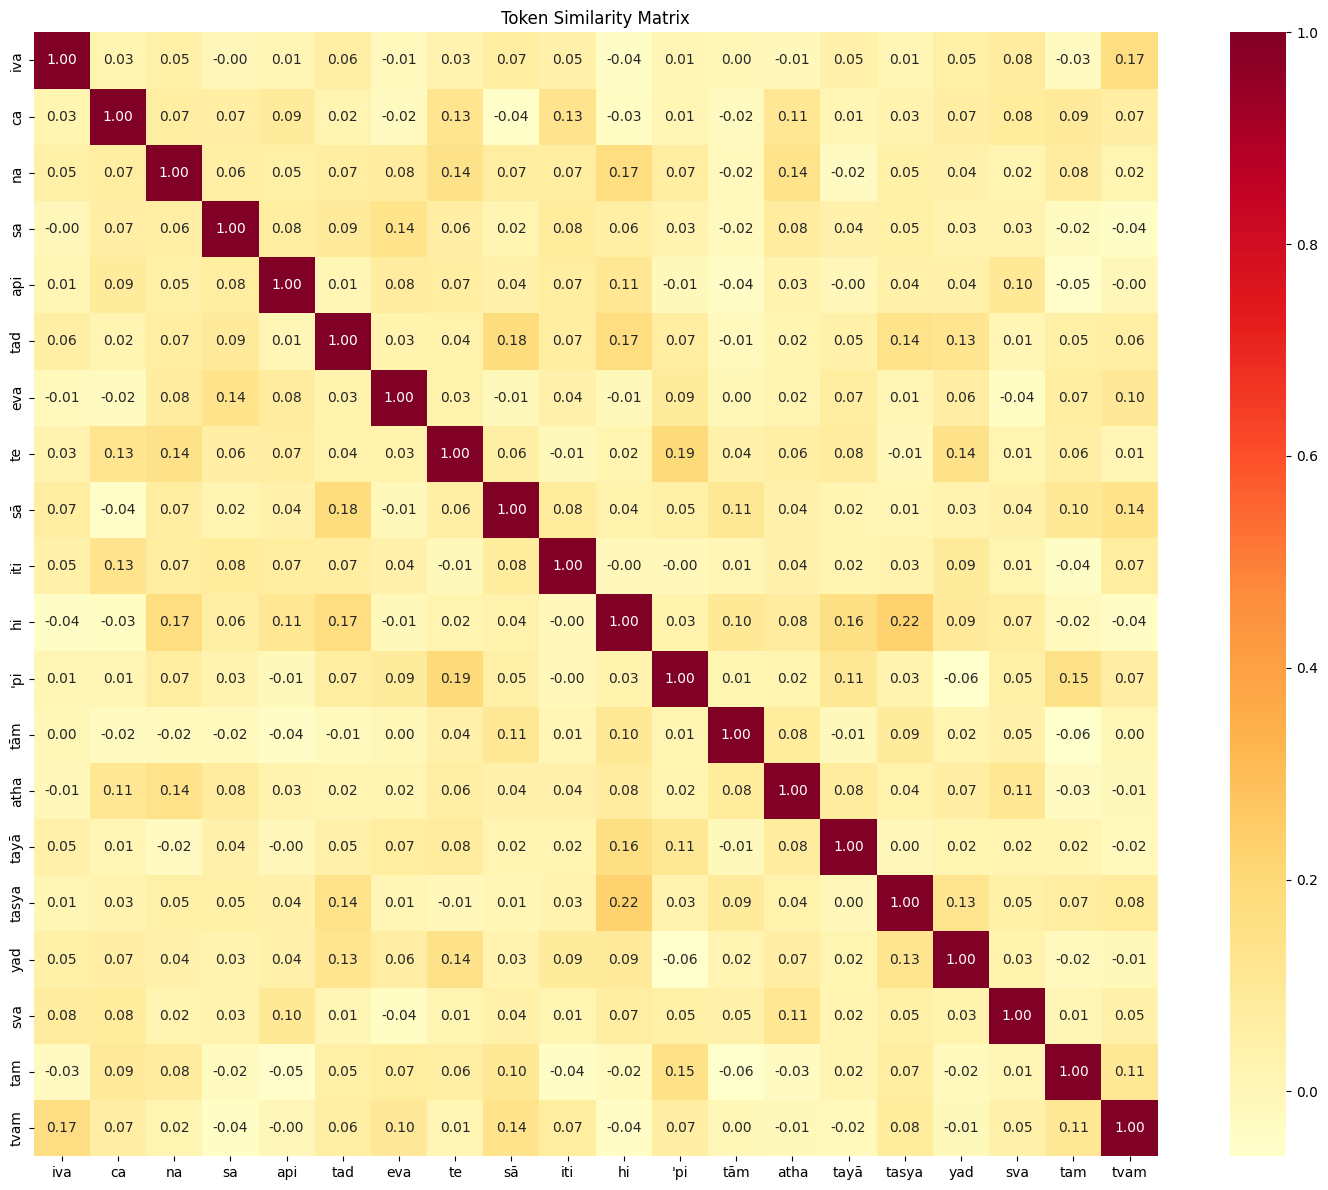

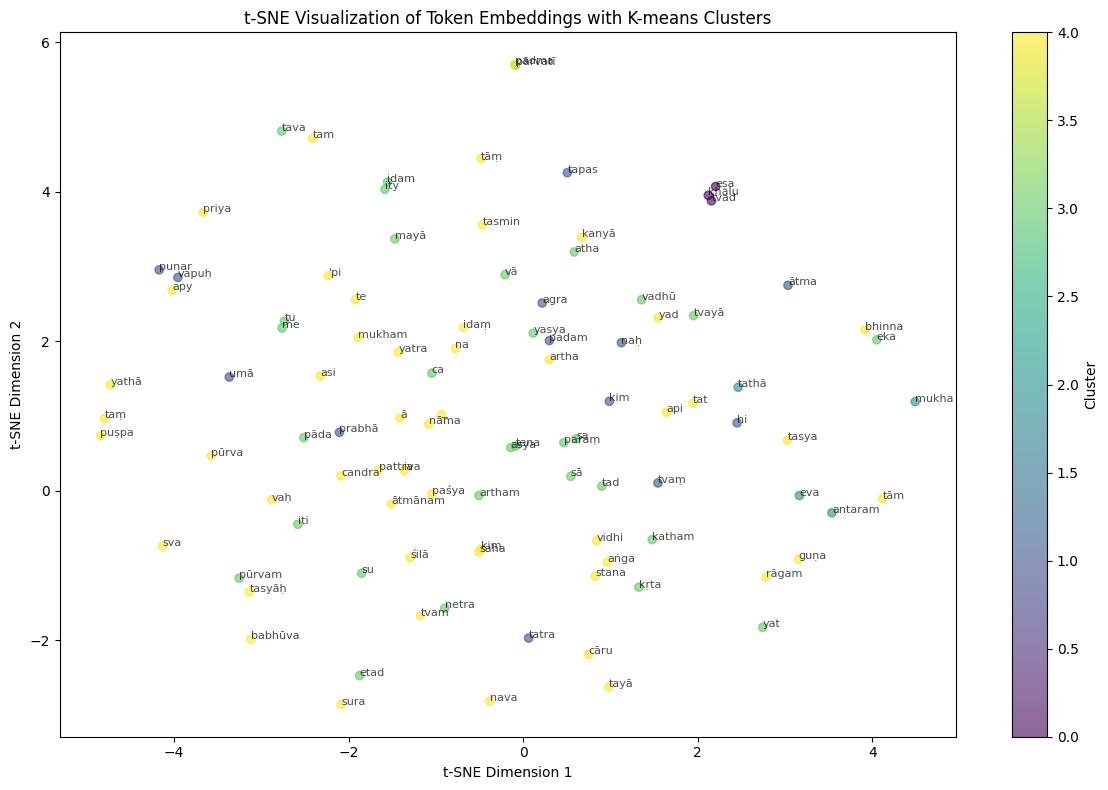

K-means Clusters: %s {'ātmā': 1, 'nāma': 1, 'naga': 1, 'pūrva': 1, 'iva': 1, 'māna': 2, 'yaṃ': 2, 'sarva': 2, 'mahā': 2, 'ca': 1, 'ratna': 4, 'yasya': 2, 'na': 4, 'saubhāgya': 2, 'hi': 4, 'guṇa': 4, 'indoḥ': 2, 'bibharti': 1, 'vibhakta': 1, 'tām': 2, 'adhas': 2, 'sa': 0, 'śṛṅgāṇi': 2, 'padaṃ': 2, 'tuṣāra': 2, 'a': 2, 'api': 3, 'nakha': 2, 'dhātu': 2, 'yatra': 2, 'tvacaḥ': 2, 'bindu': 2, 'sundarīṇām': 2, 'anaṅga': 2, 'yaḥ': 2, 'tvam': 2, 'kapola': 2, '_': 1, 'tayā': 1, 'darī': 2, 'gṛha': 2, 'niṣakta': 2, 'bhavanti': 2, 'surata': 2, 'aṅguli': 1, "'pi": 1, 'payodhara': 2, 'gatim': 4, 'divā': 4, 'uccais': 1, 'satī': 2, 'candra': 1, 'artha': 1, 'dvāra': 2, 'vilambi': 2, 'yad': 1, 'bhinna': 1, 'saptarṣi': 4, 'hasta': 3, 'agra': 2, 'avekṣya': 2, 'kalpita': 2, 'śaila': 2, 'svayam': 2, 'sakhaḥ': 1, 'ātma': 2, 'vidhinā': 2, 'kāla': 1, 'atha': 2, 'tayoḥ': 2, 'sva': 2, 'rūpa': 2, 'rāja': 2, 'sā': 2, 'vadhū': 2, 'baddha': 3, 'pituḥ': 2, 'kanyā': 2, 'bhava': 3, 'visṛṣṭa': 3, 'tāṃ': 2, 'prapede': 2, 

/tmp/ipykernel_31/3006046115.py:101: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/tmp/ipykernel_31/3006046115.py:136: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



Epoch 1/20, Train Loss: 4.7509, Val Loss: 4.7712
Epoch 2/20, Train Loss: 4.0561, Val Loss: 4.8607
Epoch 3/20, Train Loss: 3.6741, Val Loss: 5.0650
Epoch 4/20, Train Loss: 3.3366, Val Loss: 5.1111
Epoch 5/20, Train Loss: 2.9902, Val Loss: 5.3058
Epoch 6/20, Train Loss: 2.6557, Val Loss: 5.2696
Epoch 7/20, Train Loss: 2.2853, Val Loss: 5.0306
Epoch 8/20, Train Loss: 1.9204, Val Loss: 5.2060
Epoch 9/20, Train Loss: 1.4778, Val Loss: 5.2956
Epoch 10/20, Train Loss: 1.0386, Val Loss: 5.6301
Epoch 11/20, Train Loss: 0.6950, Val Loss: 5.5204
Epoch 12/20, Train Loss: 0.4816, Val Loss: 5.7340
Epoch 13/20, Train Loss: 0.3491, Val Loss: 5.8533
Epoch 14/20, Train Loss: 0.2793, Val Loss: 5.7187
Epoch 15/20, Train Loss: 0.2197, Val Loss: 5.8574
Epoch 16/20, Train Loss: 0.1397, Val Loss: 5.9017
Epoch 17/20, Train Loss: 0.1164, Val Loss: 6.0000
Epoch 18/20, Train Loss: 0.1132, Val Loss: 5.9646
Epoch 19/20, Train Loss: 0.1056, Val Loss: 6.0226
Epoch 20/20, Train Loss: 0.1033, Val Loss: 6.0629

Step 8: 

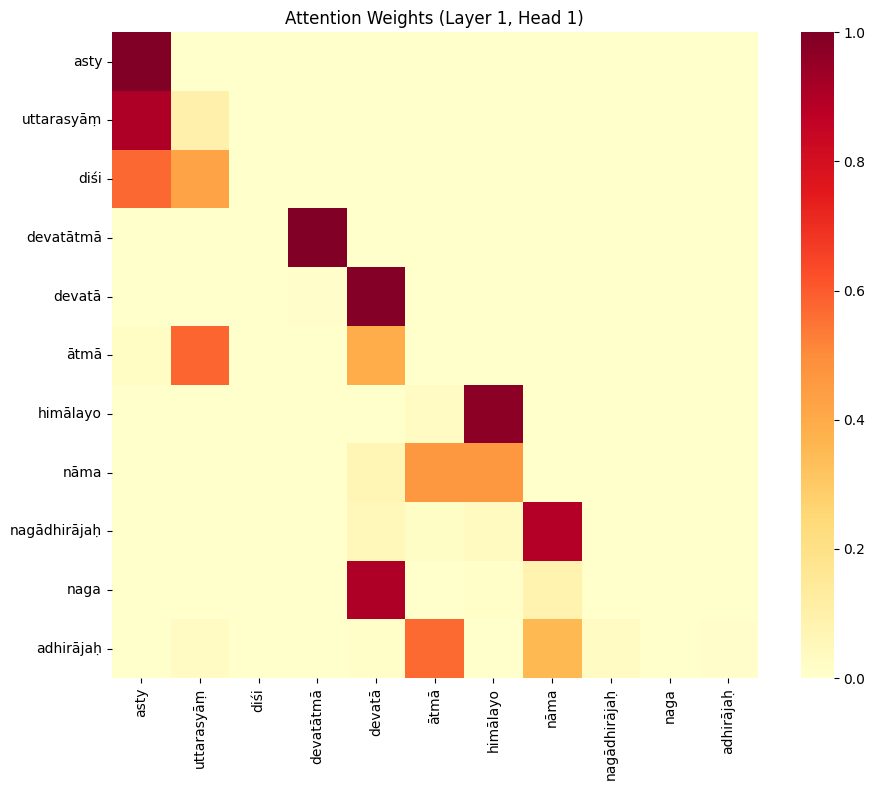

/tmp/ipykernel_31/1071573264.py:156: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



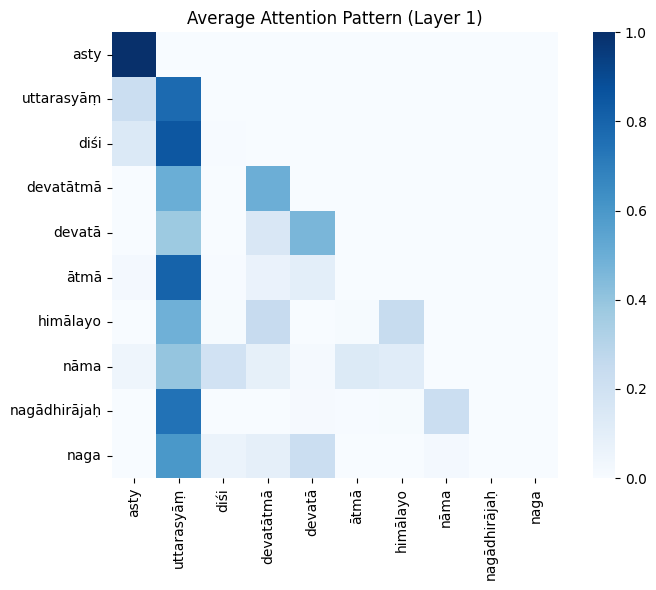

/tmp/ipykernel_31/1071573264.py:178: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/tmp/ipykernel_31/1071573264.py:207: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



Average Attention Entropy: 1.3571
Average Attention Sparsity: 0.4923
Layer 1, Head 1 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 1, Head 2 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 1, Head 3 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 1, Head 4 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294


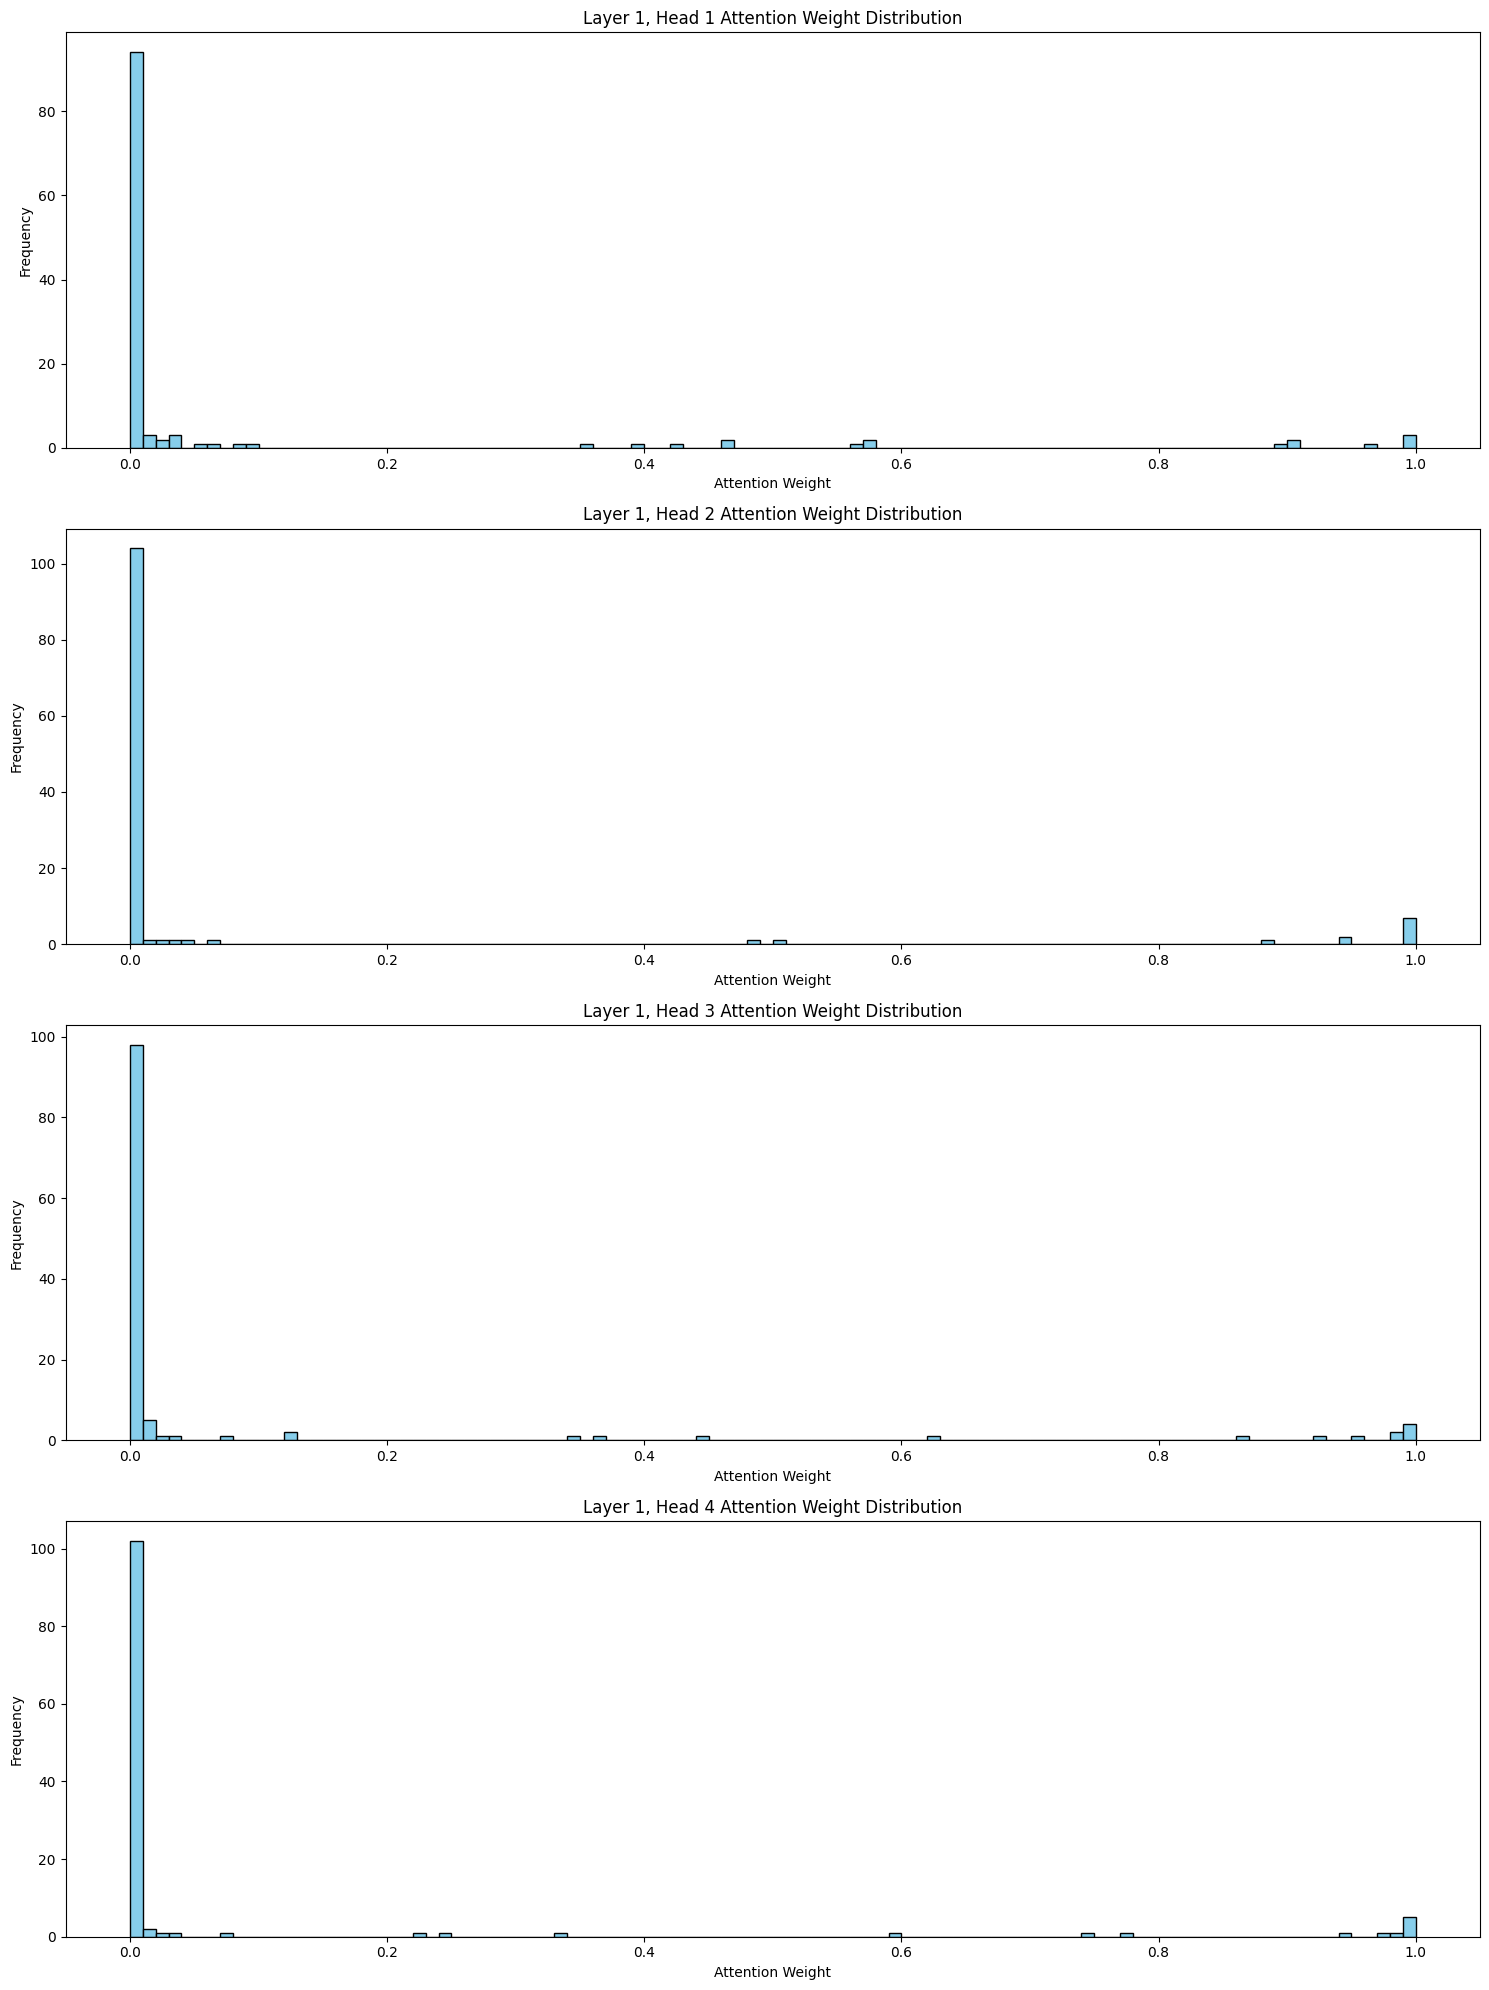

Layer 2, Head 1 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 2, Head 2 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 2, Head 3 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 2, Head 4 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294


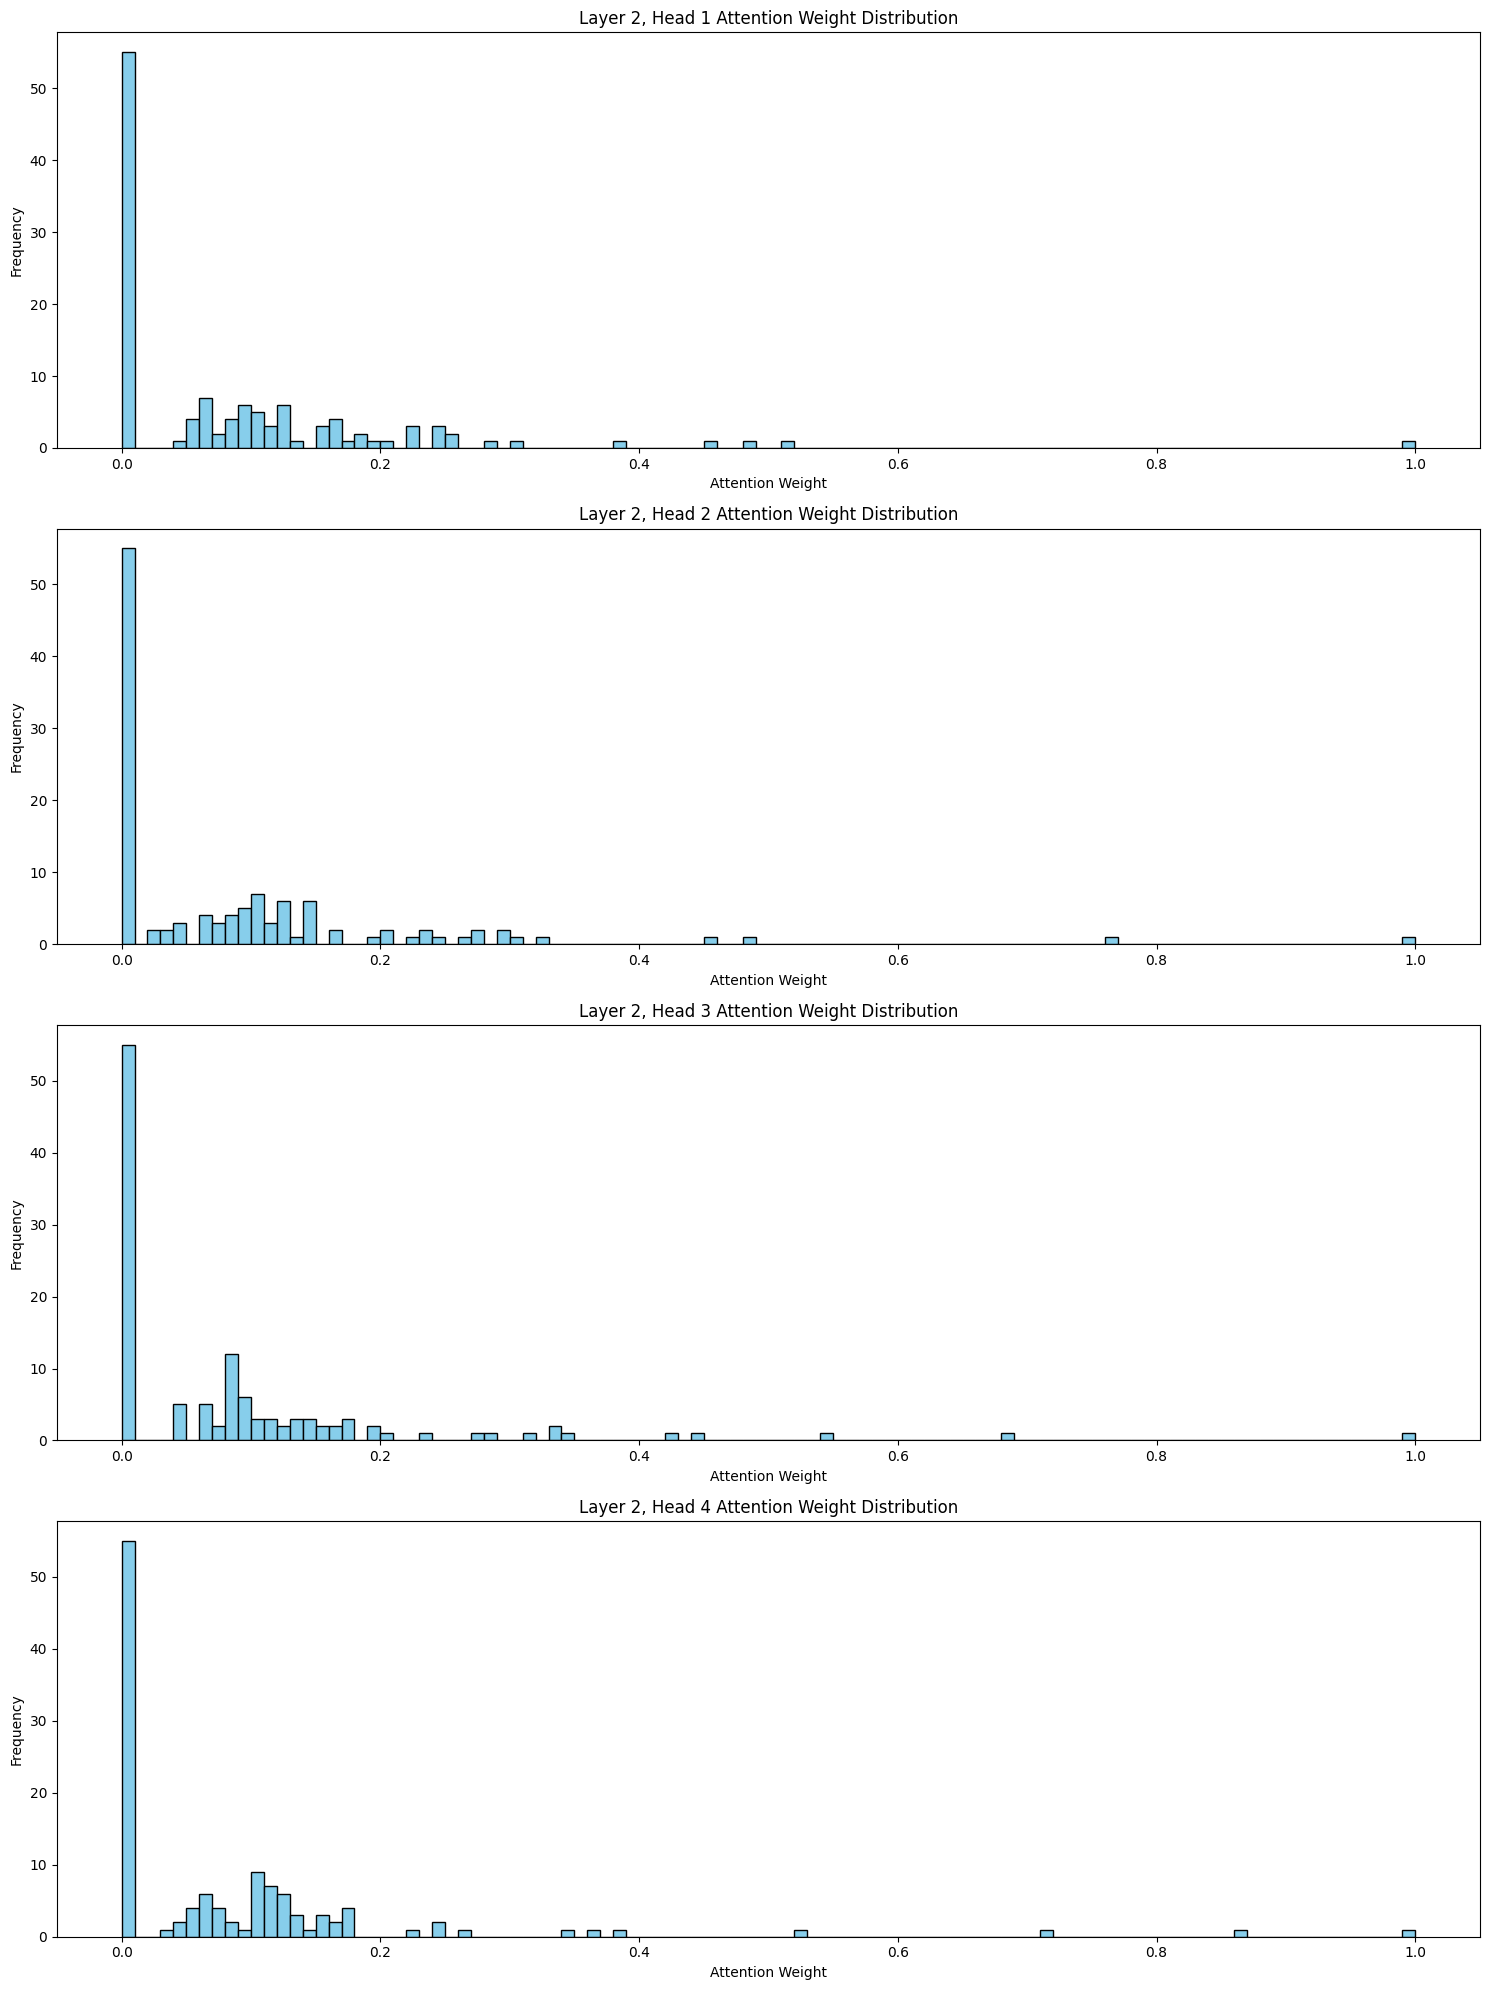

Layer 3, Head 1 - Weights min: 0.0, max: 1.0, mean: 0.09090910106897354
Layer 3, Head 2 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 3, Head 3 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 3, Head 4 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294


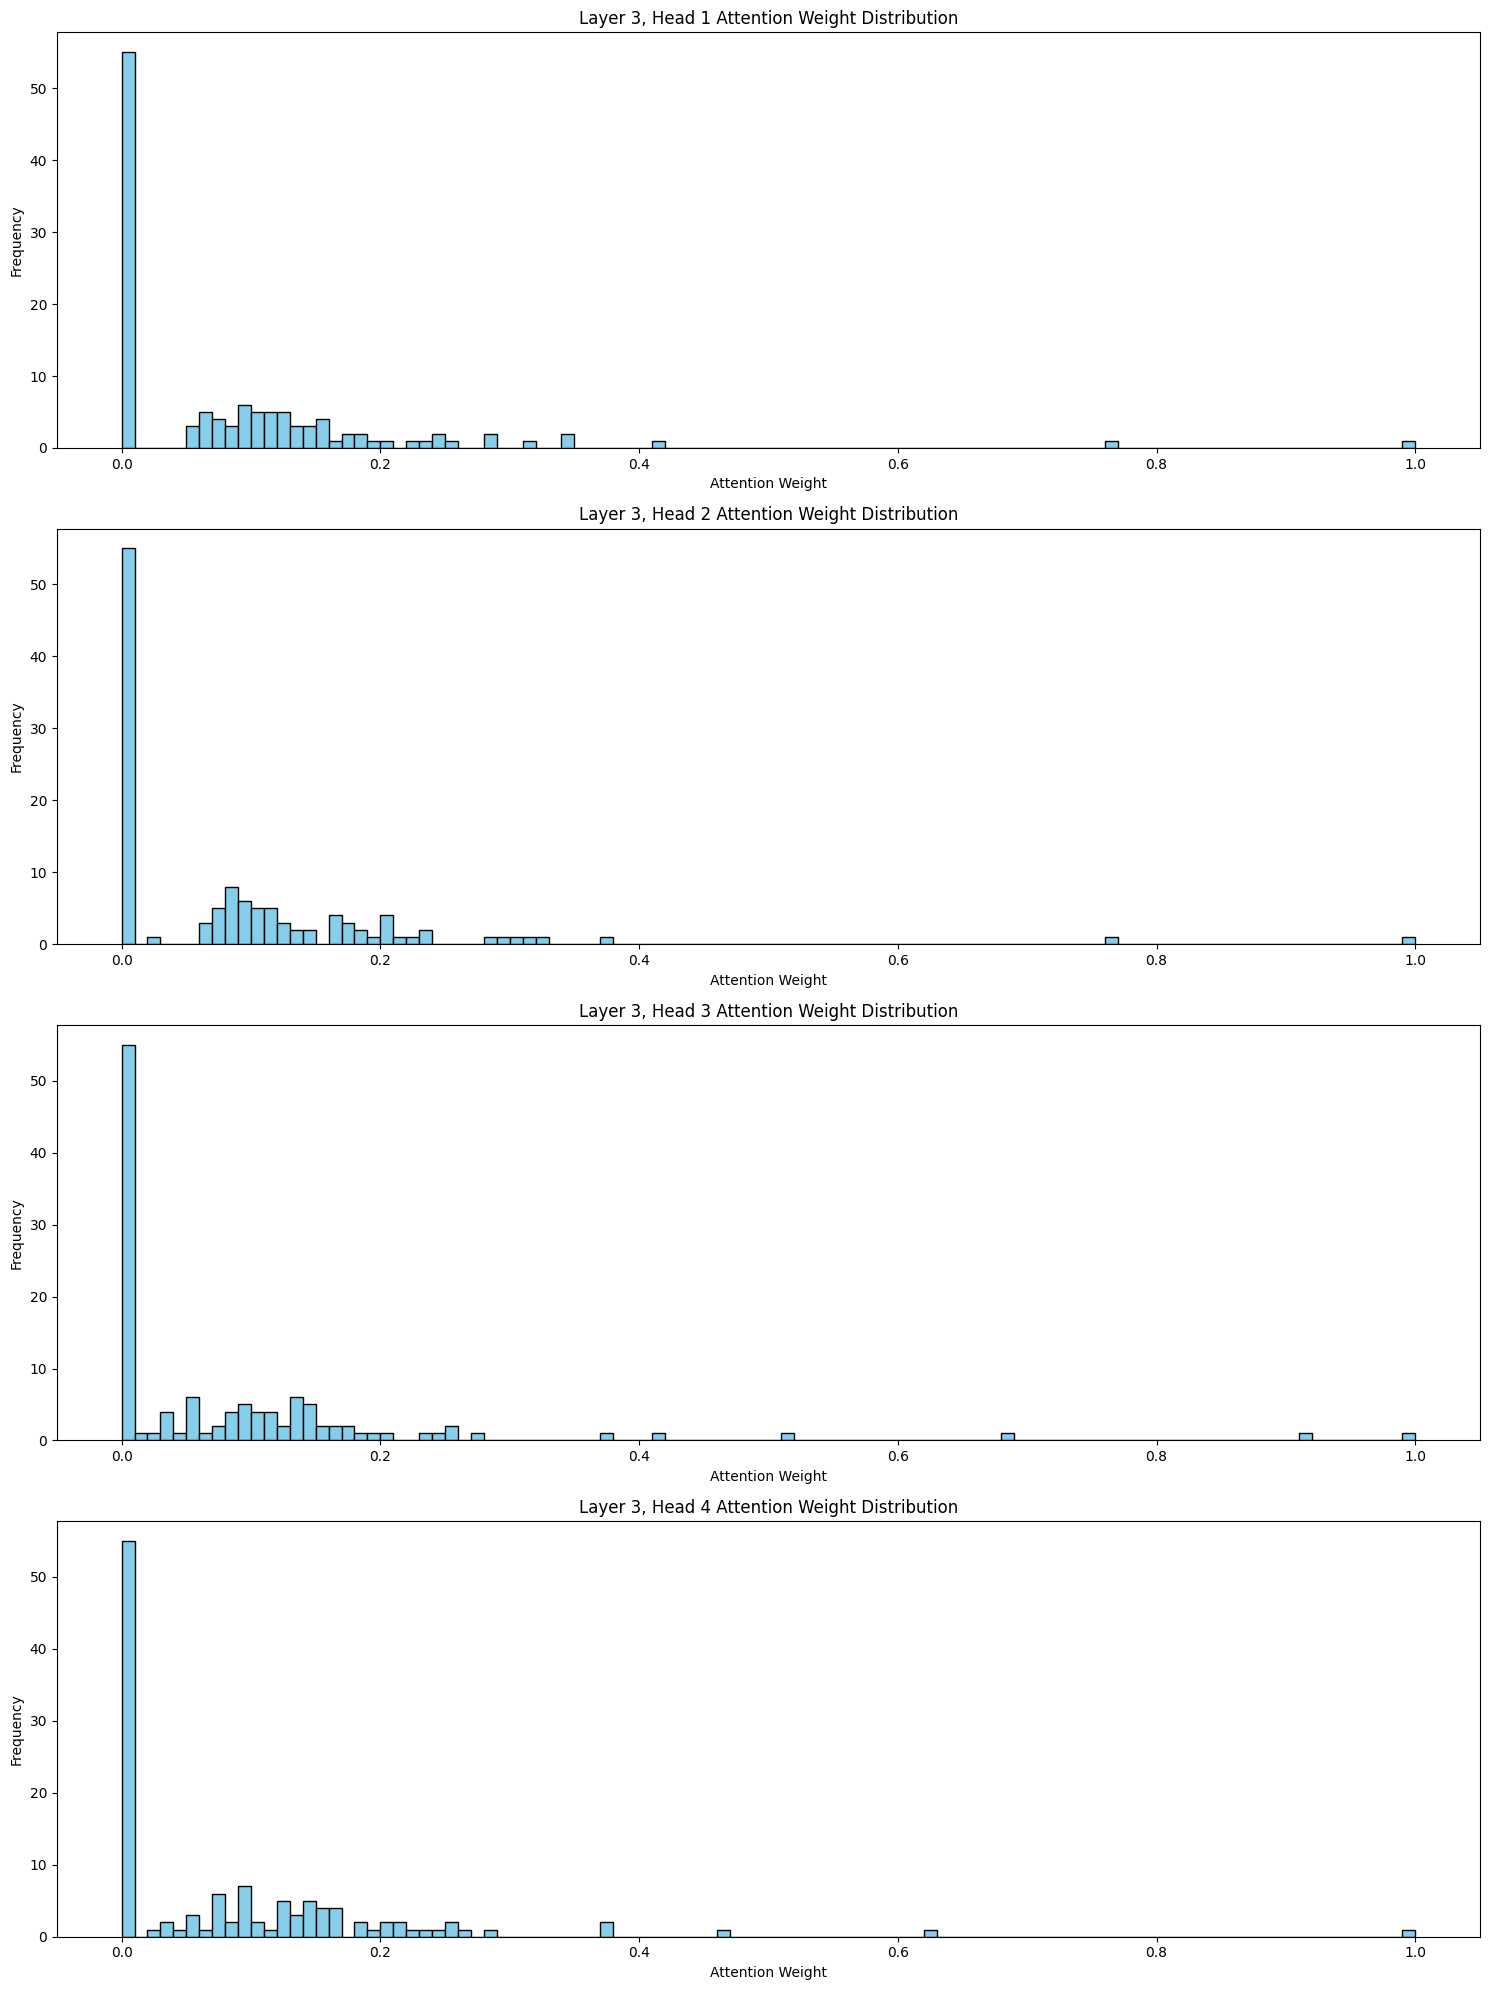

Layer 4, Head 1 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 4, Head 2 - Weights min: 0.0, max: 1.0, mean: 0.09090908616781235
Layer 4, Head 3 - Weights min: 0.0, max: 1.0, mean: 0.09090910106897354
Layer 4, Head 4 - Weights min: 0.0, max: 1.0, mean: 0.09090910106897354


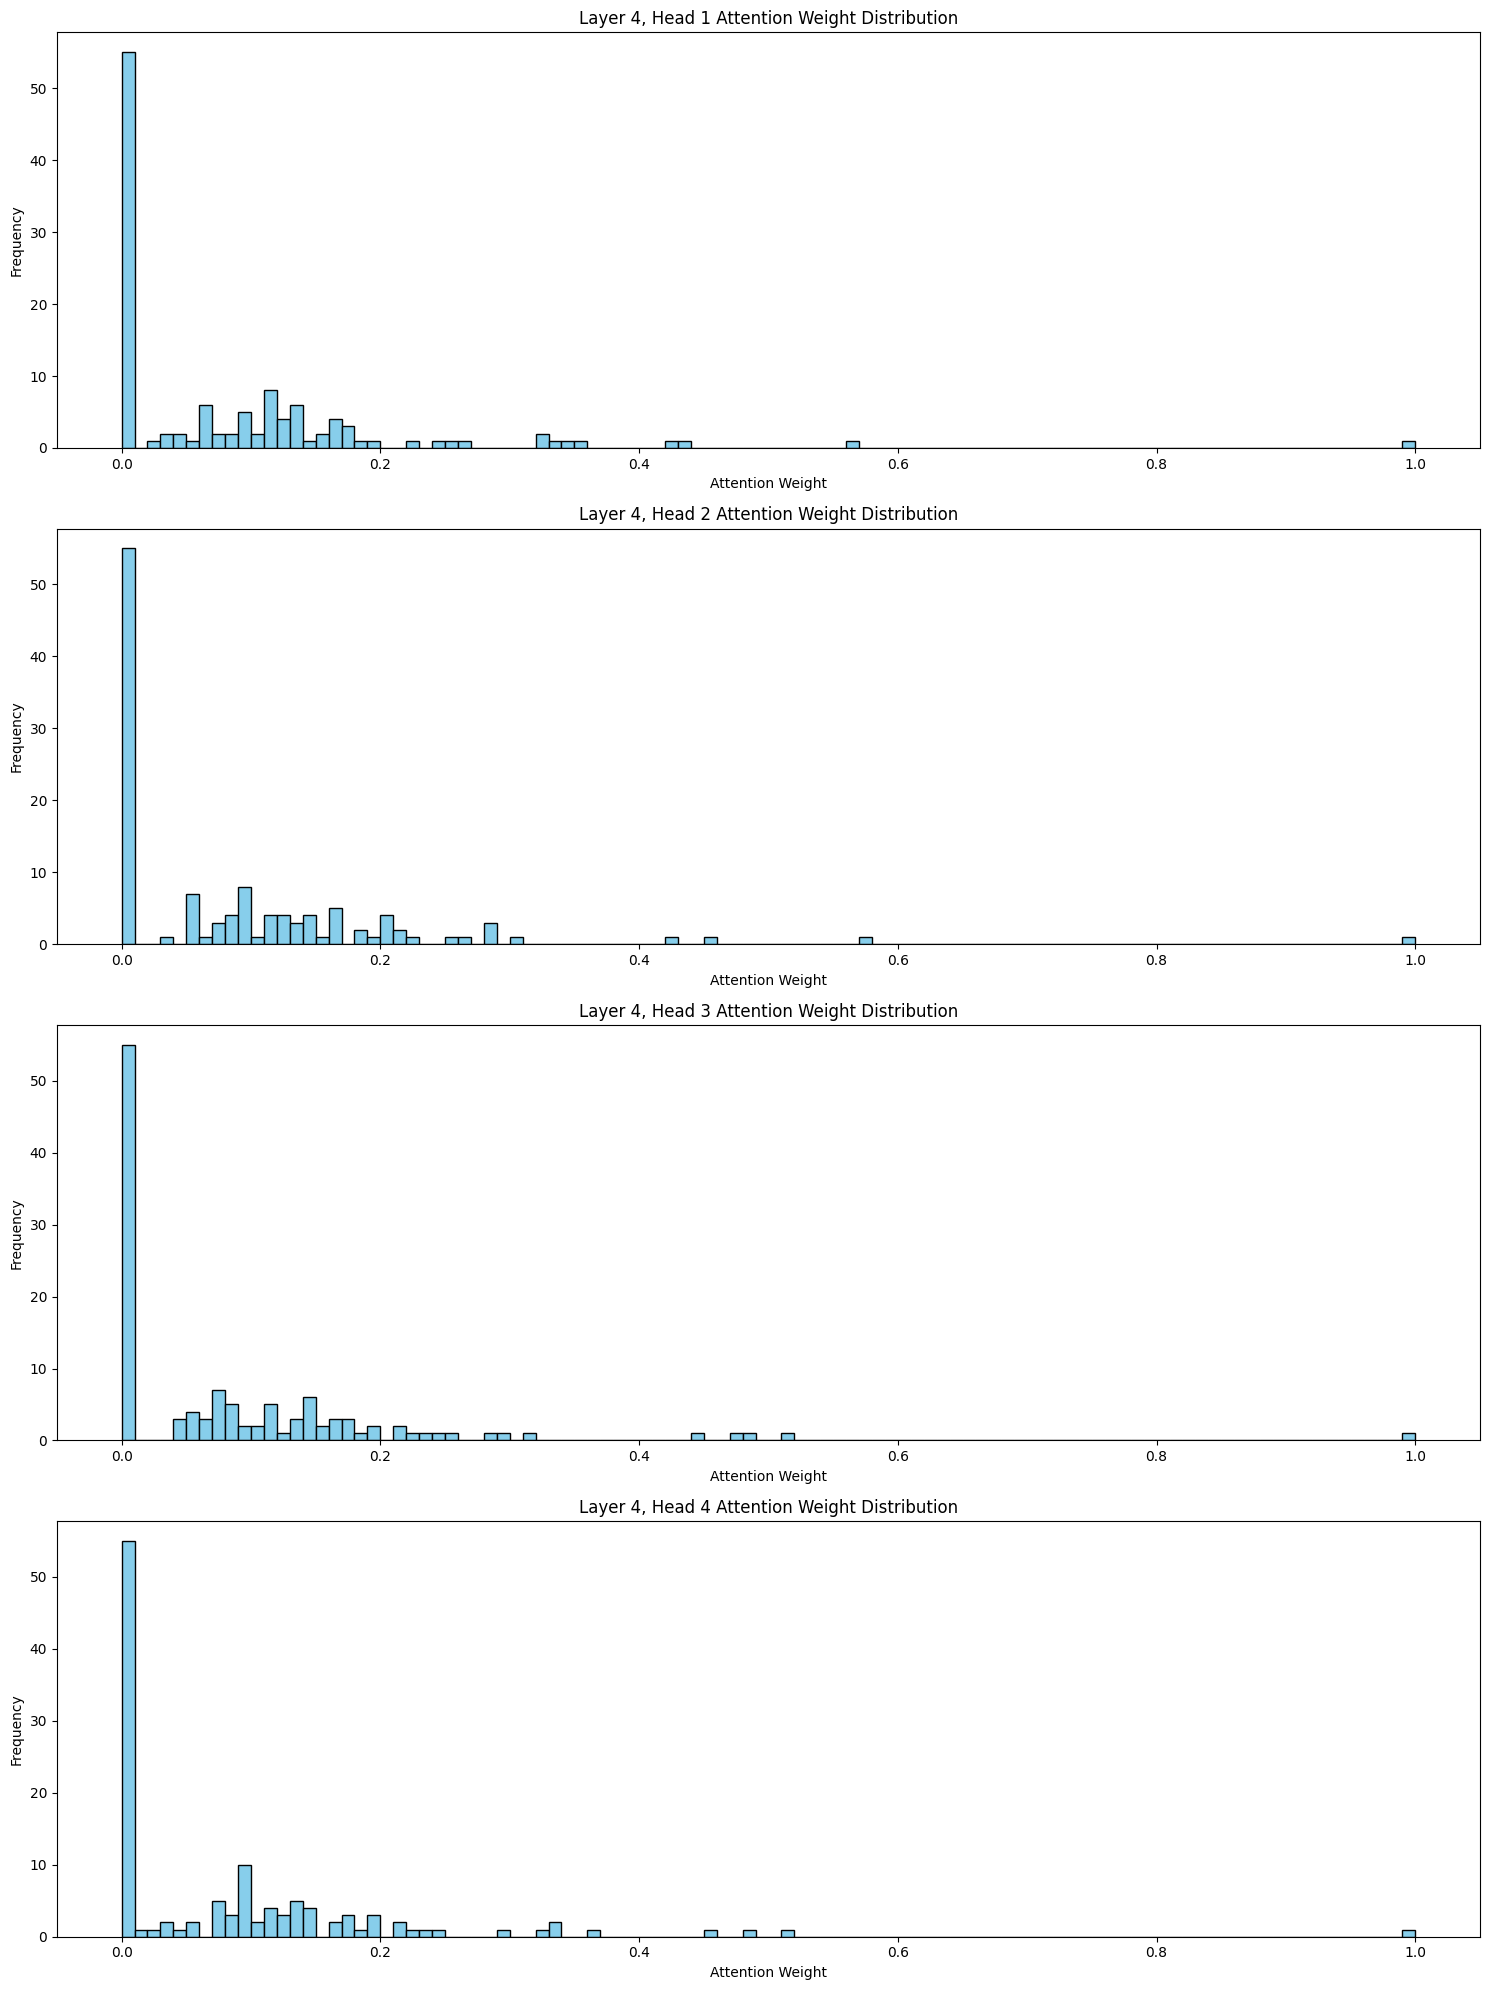

Layer 5, Head 1 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 5, Head 2 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 5, Head 3 - Weights min: 0.0, max: 1.0, mean: 0.09090908616781235
Layer 5, Head 4 - Weights min: 0.0, max: 1.0, mean: 0.09090908616781235


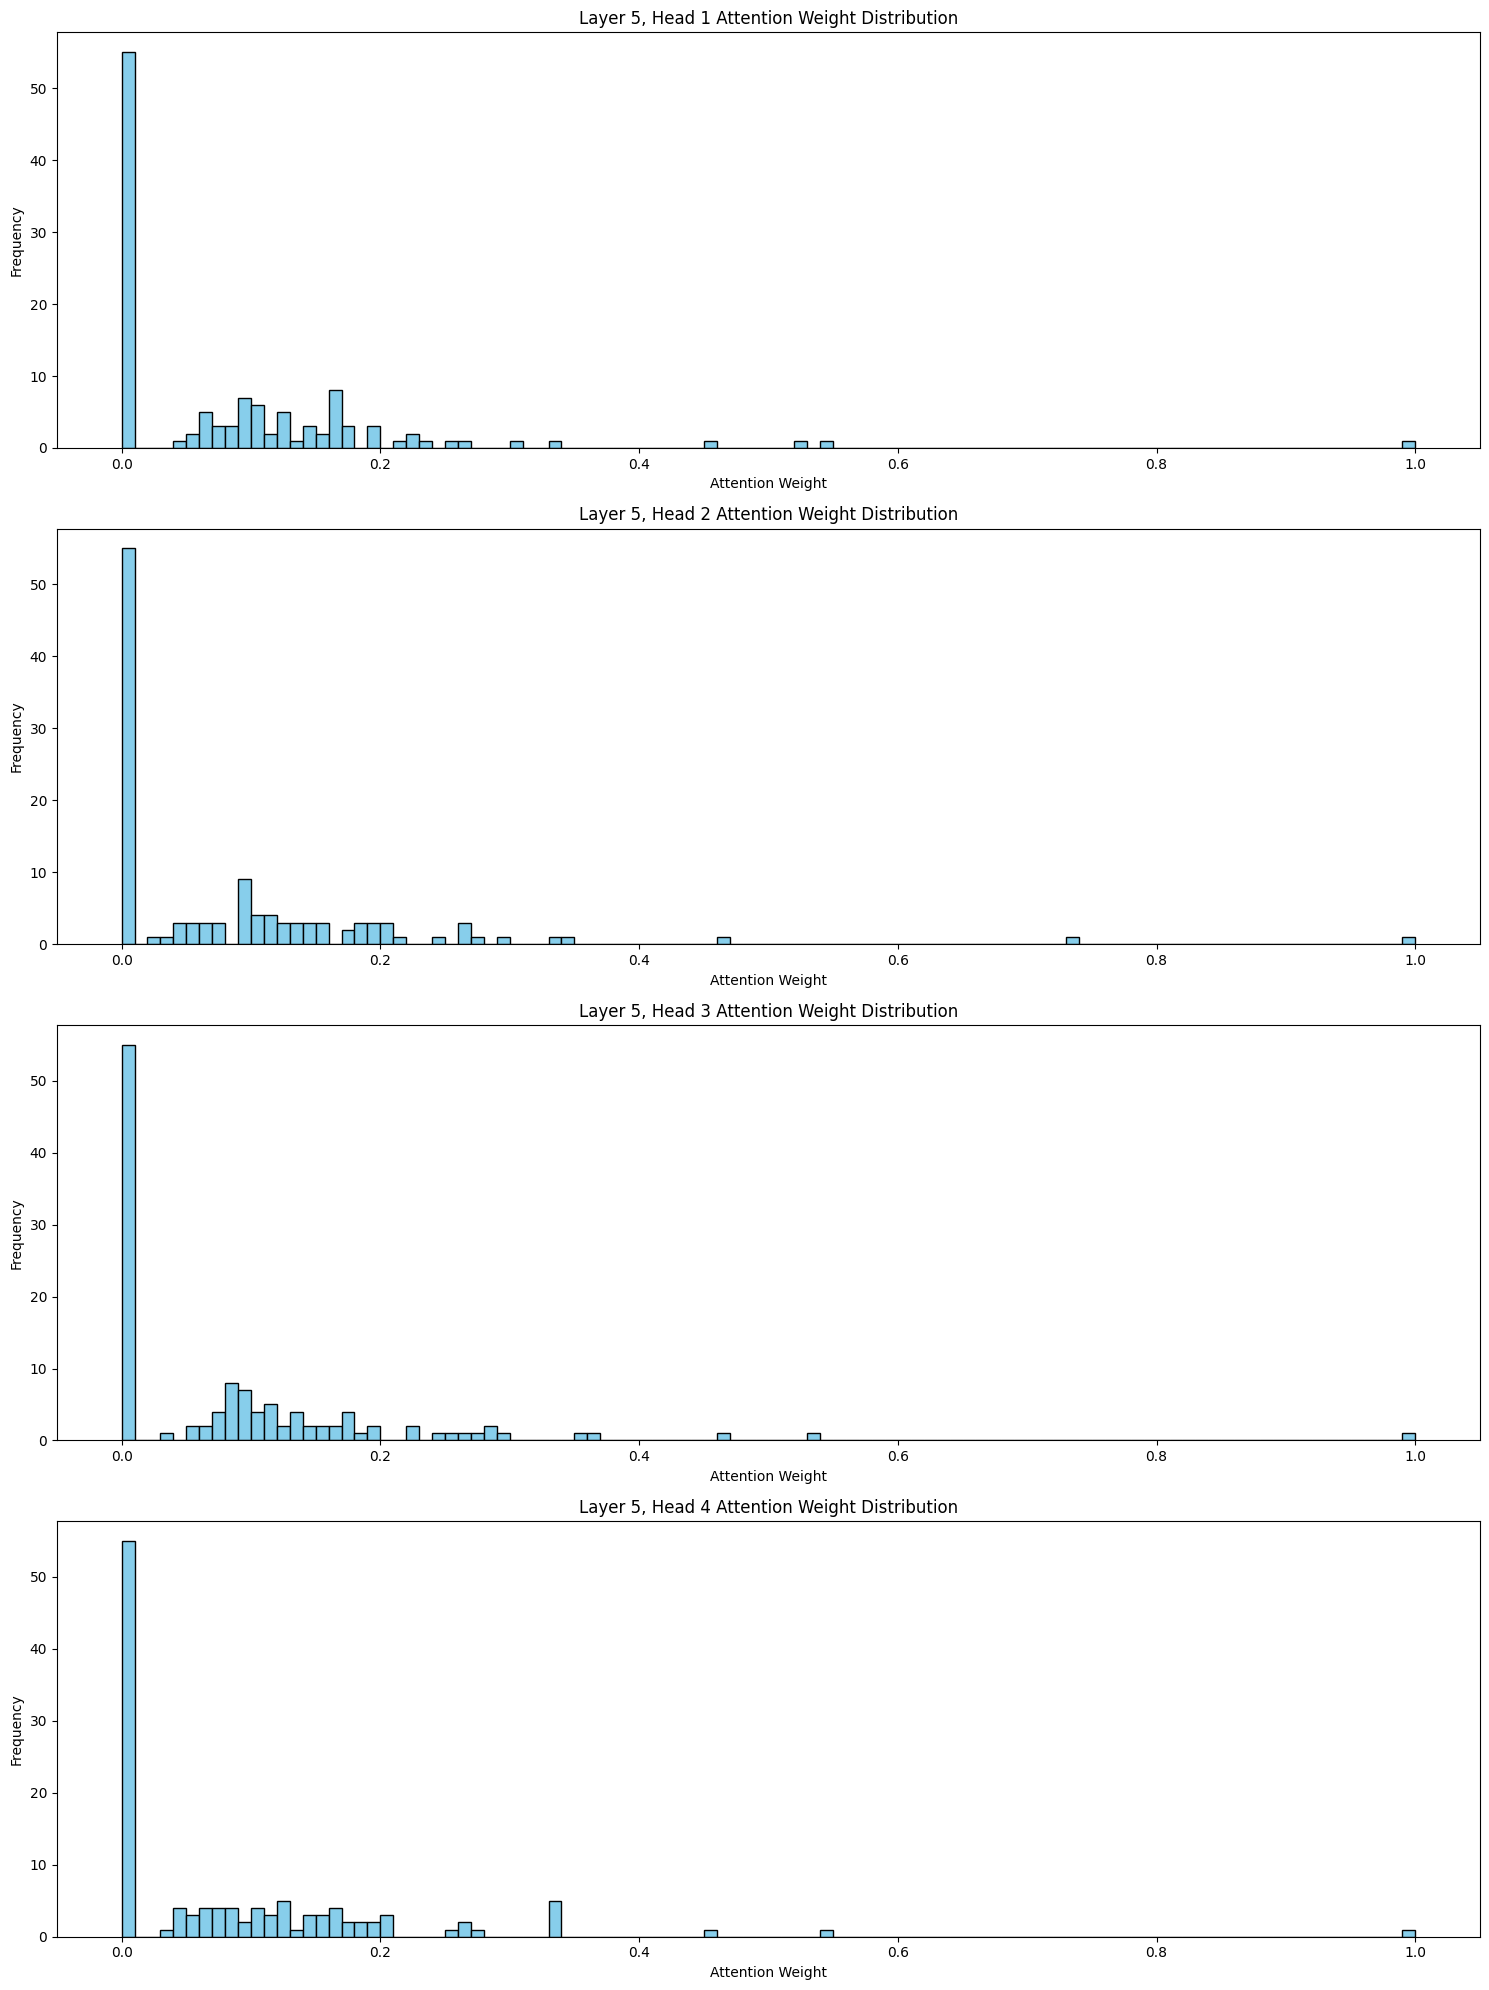

Layer 6, Head 1 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 6, Head 2 - Weights min: 0.0, max: 1.0, mean: 0.09090908616781235
Layer 6, Head 3 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 6, Head 4 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294


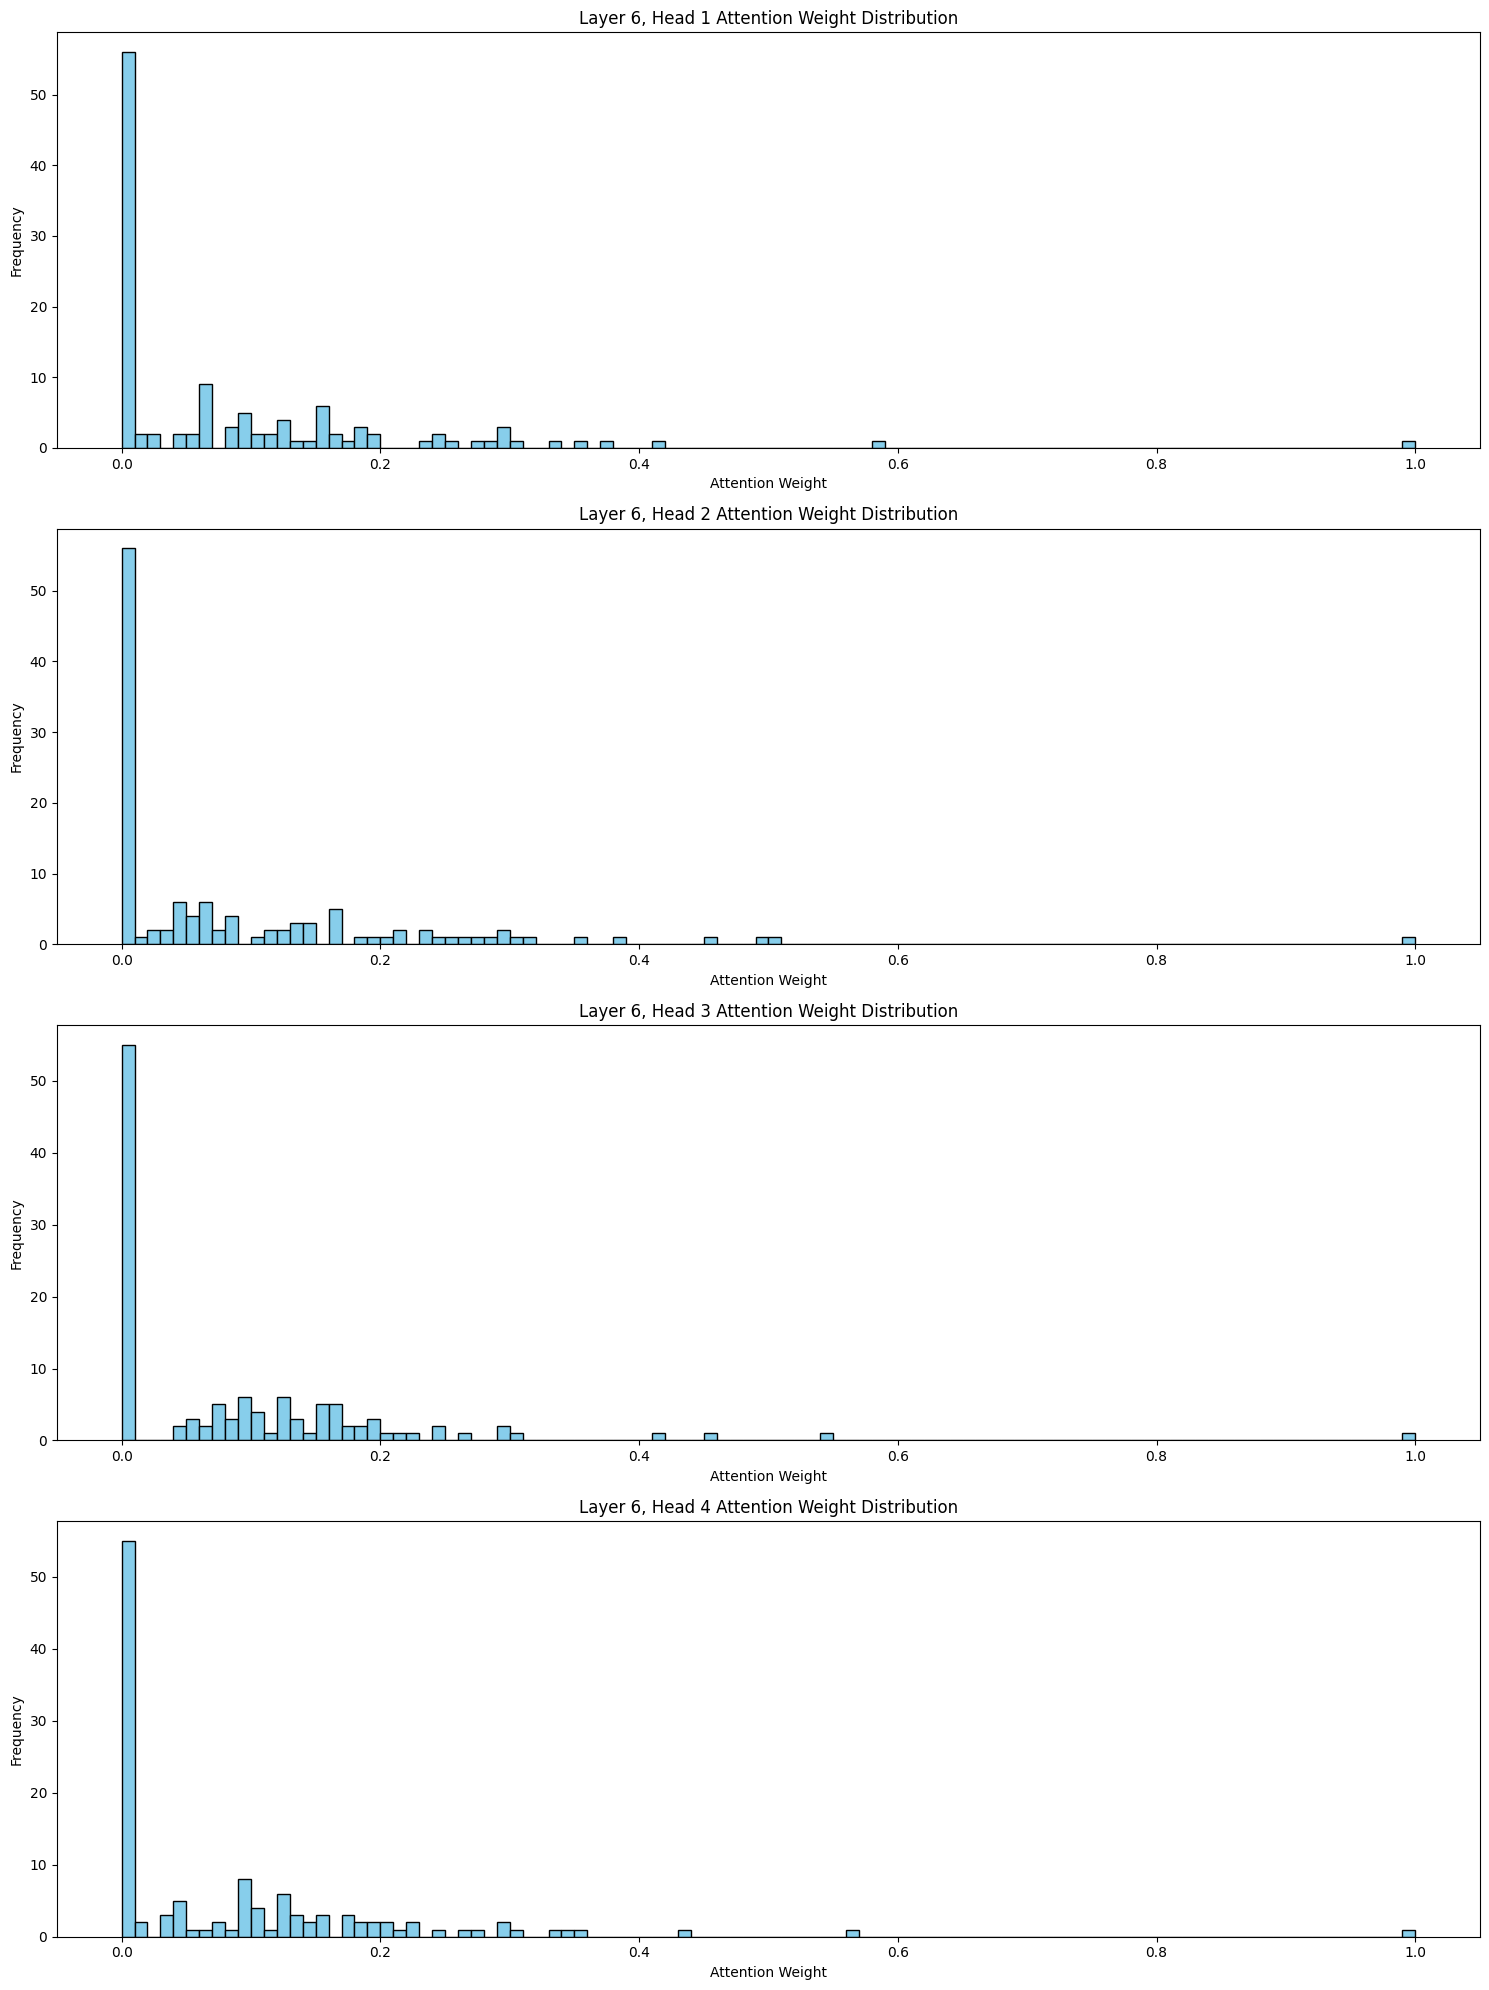

Layer 7, Head 1 - Weights min: 0.0, max: 1.0, mean: 0.09090910106897354
Layer 7, Head 2 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 7, Head 3 - Weights min: 0.0, max: 1.0, mean: 0.09090910106897354
Layer 7, Head 4 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294


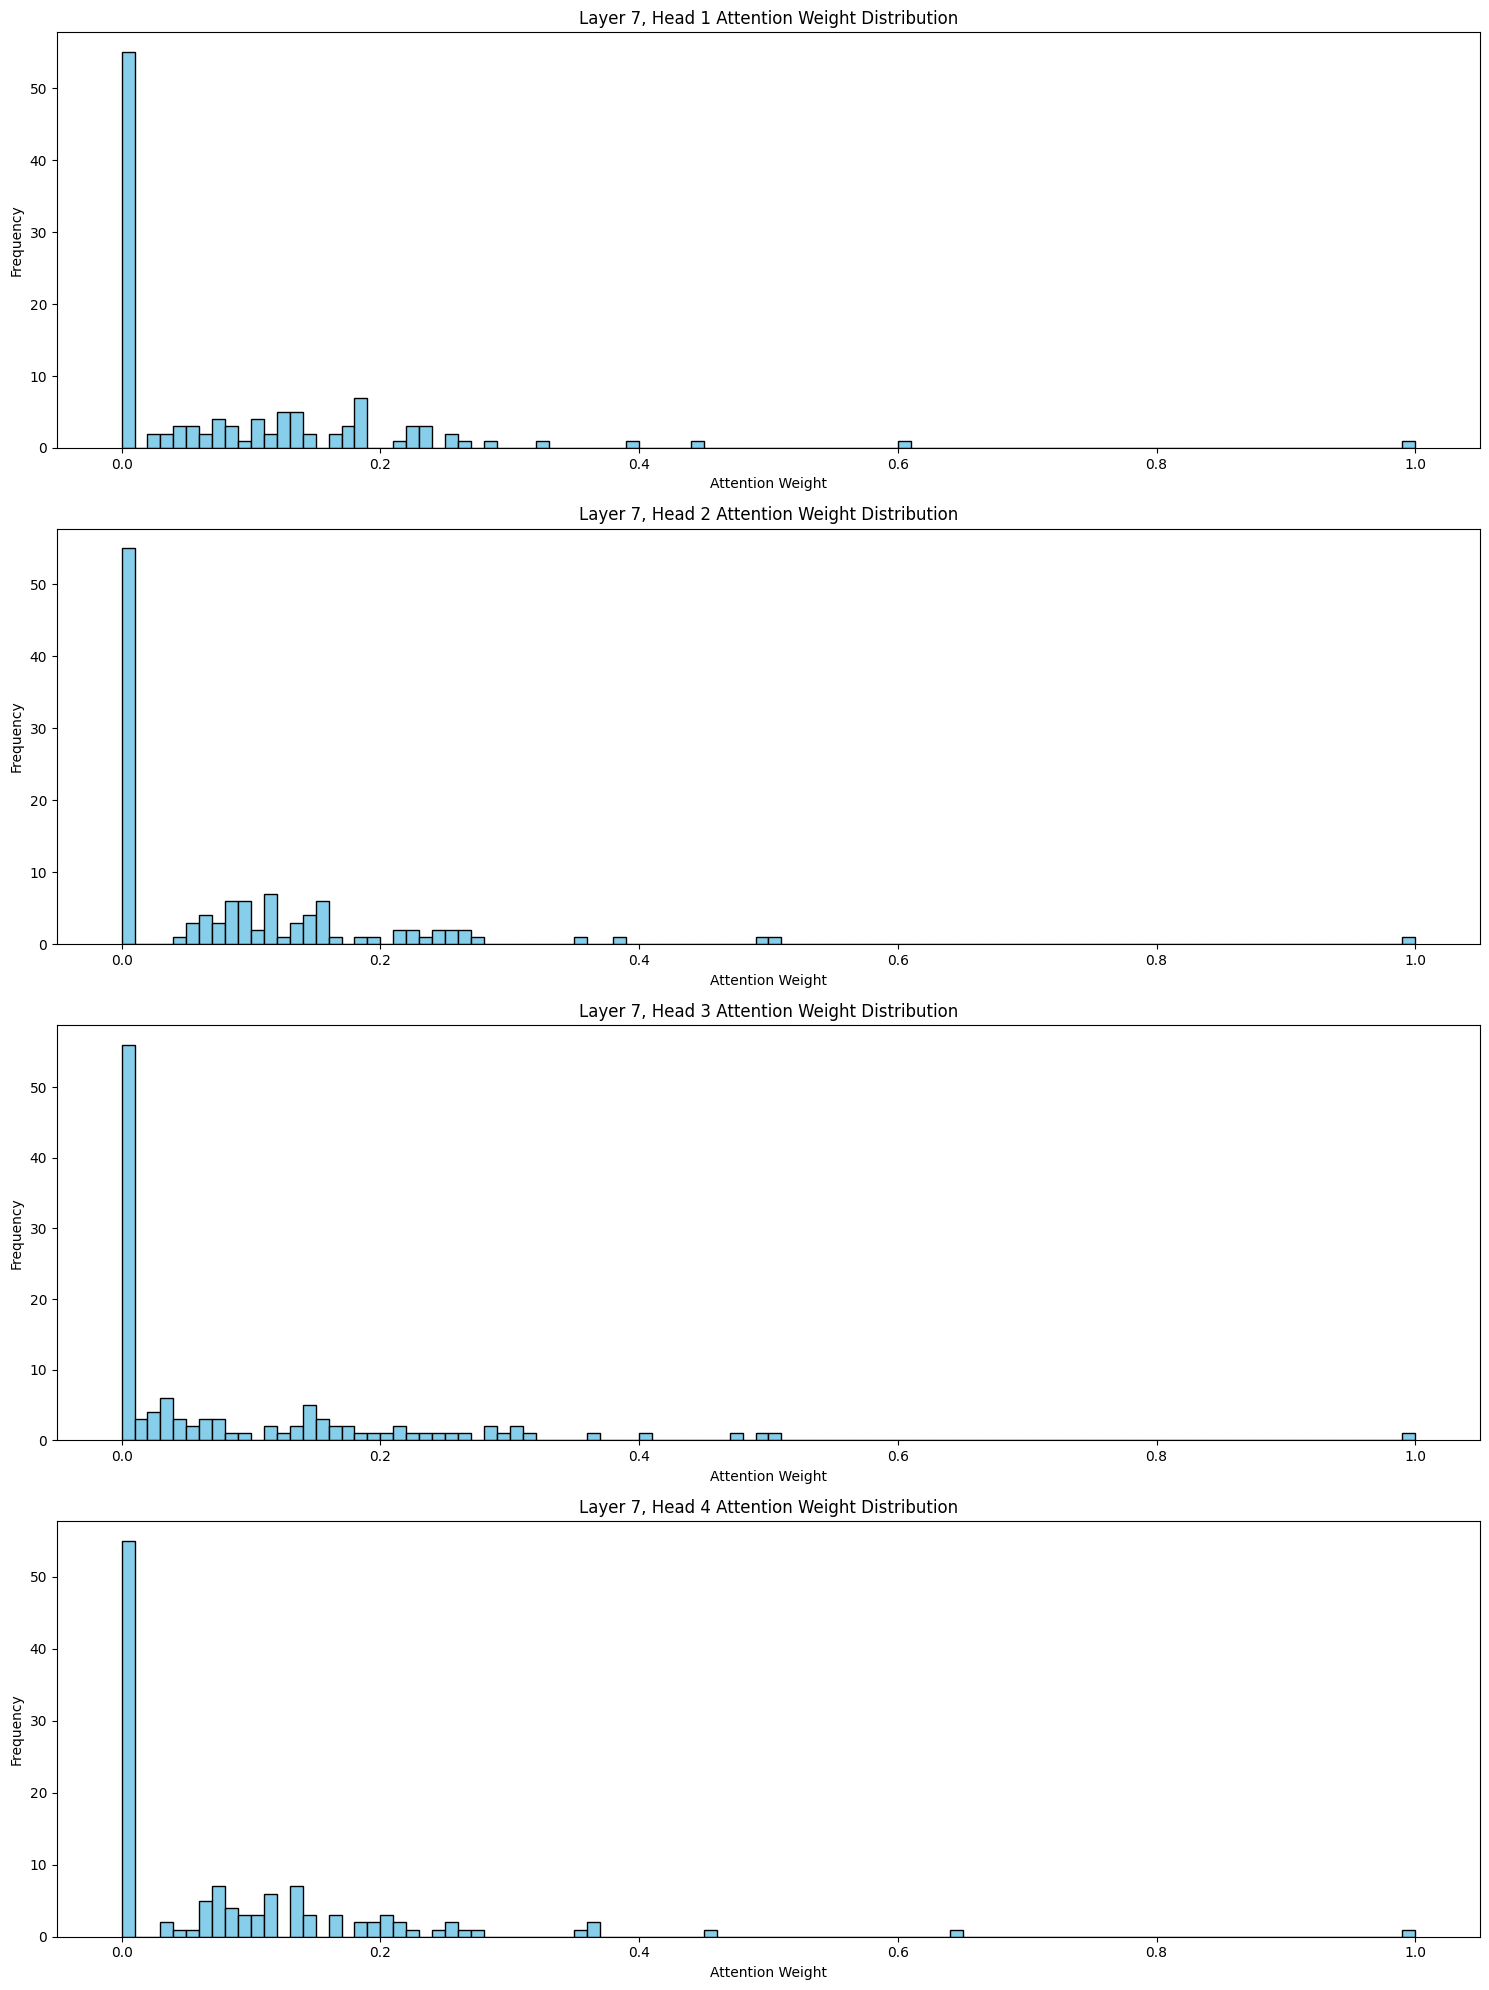

Layer 8, Head 1 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 8, Head 2 - Weights min: 0.0, max: 1.0, mean: 0.09090910106897354
Layer 8, Head 3 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294
Layer 8, Head 4 - Weights min: 0.0, max: 1.0, mean: 0.09090909361839294


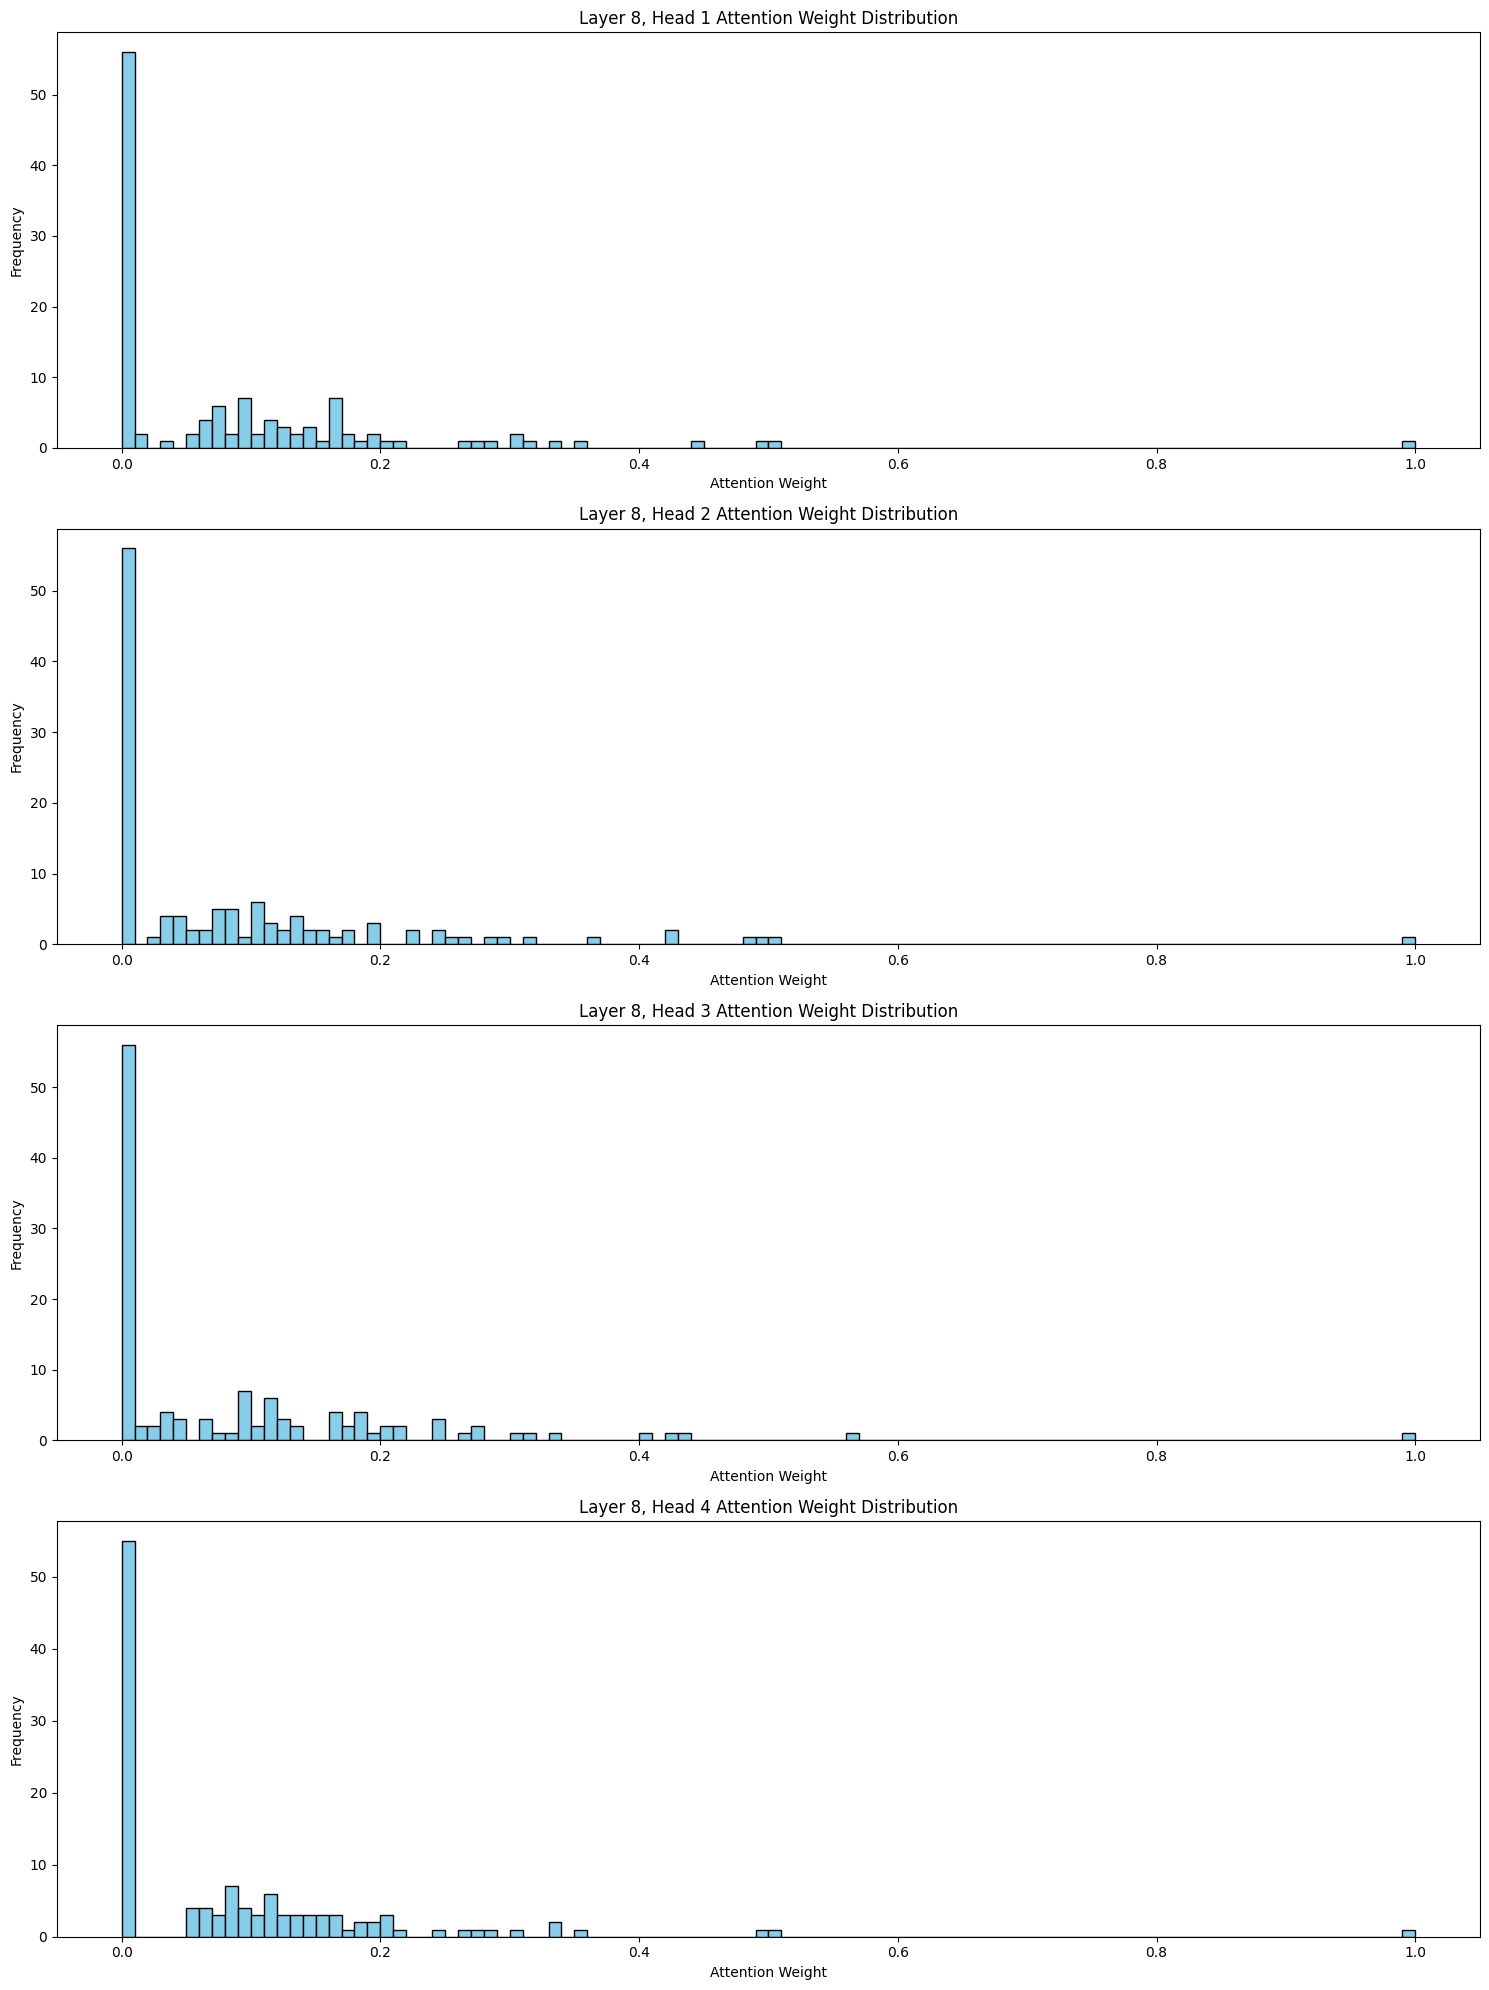

/tmp/ipykernel_31/1071573264.py:237: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



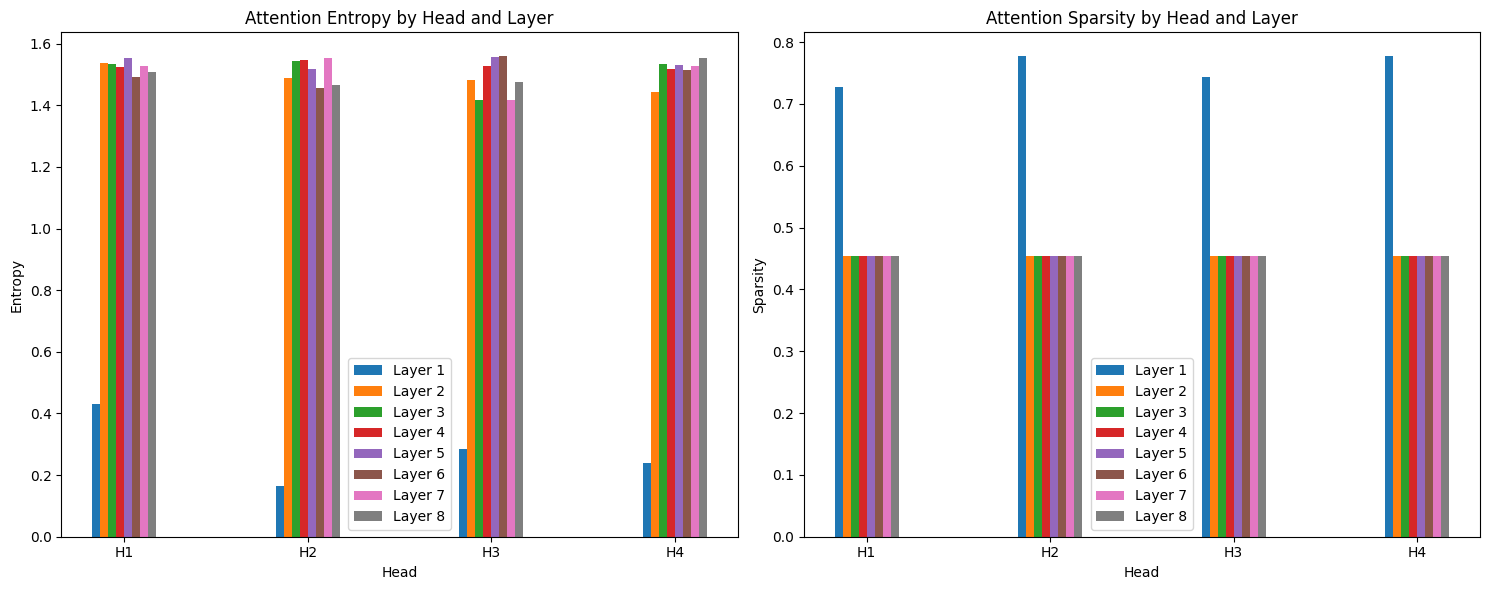

/tmp/ipykernel_31/1071573264.py:282: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.

/tmp/ipykernel_31/1071573264.py:302: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



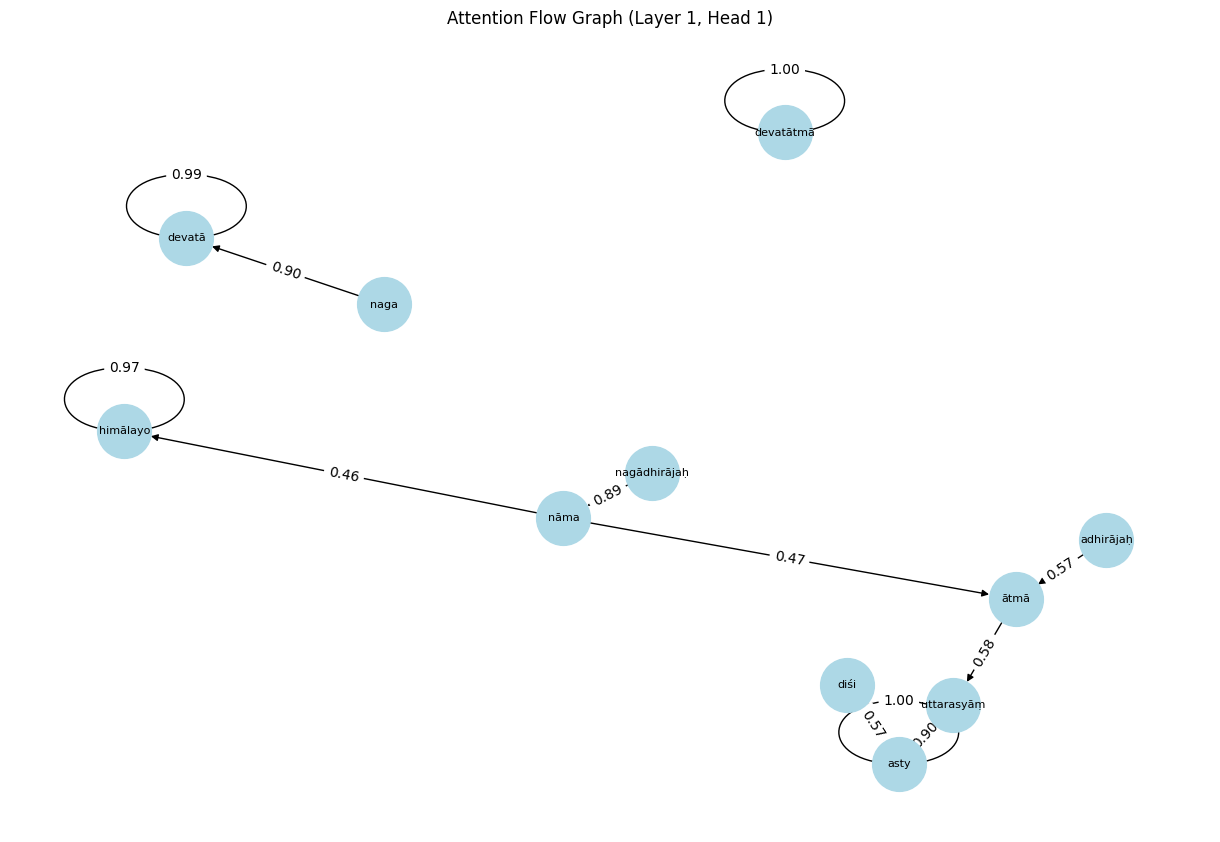

/tmp/ipykernel_31/1071573264.py:315: FutureWarning:

`torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.



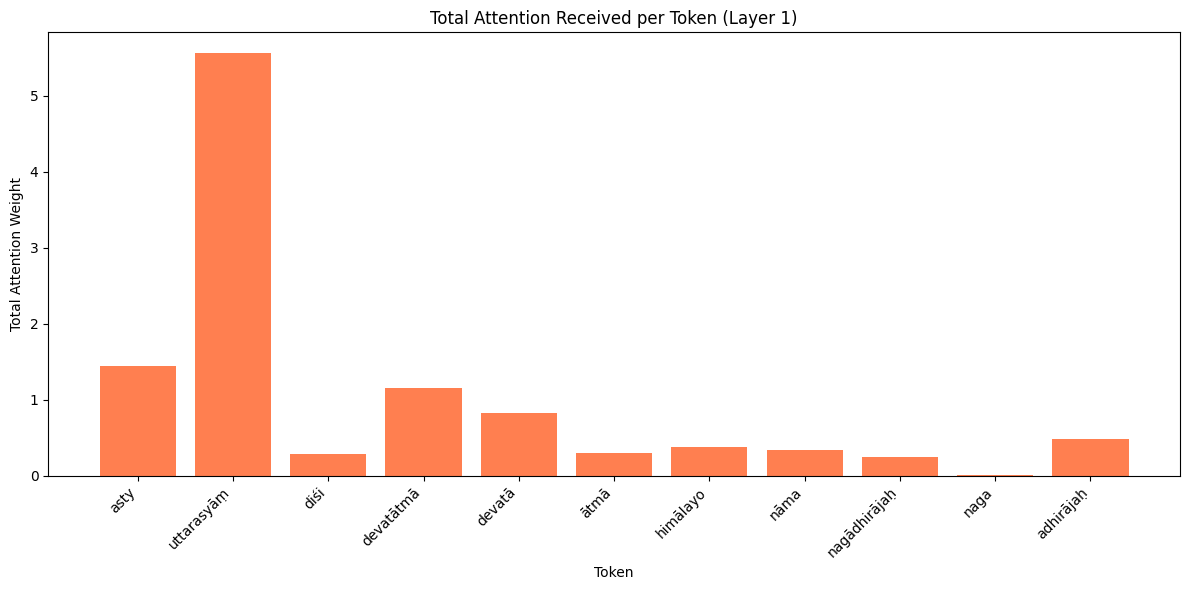


Step 9: Generating 3D t-SNE visualization...

Enhanced model demo completed successfully!


In [30]:
import plotly.graph_objects as go
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import numpy as np
import logging
import torch

def plot_3d_tsne(embedder, max_tokens=100, min_freq=2, n_clusters=5):
    """Generate an interactive 3D t-SNE visualization of token embeddings with clustering using Plotly."""
    # Select tokens with frequency >= min_freq, up to max_tokens
    tokens = [t for t in sorted(embedder.vocab.items(), key=lambda x: x[1], reverse=True)
              if t[1] >= min_freq][:max_tokens]
    token_list = [t[0] for t in tokens]
    
    if not token_list:
        logging.warning("No tokens meet min_freq for 3D t-SNE visualization.")
        return
    
    # Convert tokens to indices and get embeddings
    indices = [embedder.token_to_idx.get(t) for t in token_list]
    valid_pairs = [(t, idx) for t, idx in zip(token_list, indices) if idx is not None]
    
    if not valid_pairs:
        logging.warning("No valid tokens in token_to_idx for 3D t-SNE visualization.")
        return
    
    token_list, indices = zip(*valid_pairs)
    token_list = list(token_list)
    indices = torch.tensor(list(indices), dtype=torch.long, device=embedder.device)
    
    # Get embeddings as NumPy array
    embeddings = embedder.get_embeddings()[indices].cpu().detach().numpy()  # Updated to use get_embeddings()
    
    # Apply t-SNE with 3 components
    perplexity = min(30, len(token_list) - 1) if len(token_list) > 1 else 5
    tsne = TSNE(n_components=3, random_state=42, perplexity=perplexity, n_iter=1000)
    embeddings_3d = tsne.fit_transform(embeddings)
    
    # Apply K-means clustering for coloring
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(embeddings)
    
    # Create interactive 3D scatter plot with Plotly
    fig = go.Figure(data=[go.Scatter3d(
        x=embeddings_3d[:, 0],
        y=embeddings_3d[:, 1],
        z=embeddings_3d[:, 2],
        mode='markers+text',
        marker=dict(
            size=5,
            color=cluster_labels,
            colorscale='Viridis',
            opacity=0.6,
            colorbar=dict(title='Cluster')
        ),
        text=token_list,
        textposition='top center',
        textfont=dict(size=10),
        hovertemplate='<b>Token</b>: %{text}<br>' +
                      't-SNE 1: %{x:.2f}<br>' +
                      't-SNE 2: %{y:.2f}<br>' +
                      't-SNE 3: %{z:.2f}<br>' +
                      'Cluster: %{marker.color}<extra></extra>'
    )])
    
   

# Run the demo to create the embedder
try:
    model, embedder, token_to_id = demo_enhanced_sanskrit_language_model(use_sentencepiece=False, use_devanagari=False)
    # Now run the 3D t-SNE visualization
    plot_3d_tsne(embedder, max_tokens=100, min_freq=2, n_clusters=5)
except Exception as e:
    logging.error(f"Error running demo or visualization: {str(e)}")
    raise